In [1]:
# Bibliotecas para análise de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Bibliotecas para deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Módulo local para representação molecular
from representacao import Representacao

2025-09-07 19:35:58.063571: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 19:35:58.176835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-07 19:35:59.056191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-07 19:35:59.061305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 19:36:00.751235: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Configurações de hiperparâmetros para otimização
use_count_option = [False, True]
fp_size_option = [2048, 4096, 8192]
radius_option = [2, 3, 5]

# Análise de toxicidade intravenosa em ratos

In [3]:
# Configurações do experimento
arquivo_classificado = "rat_vi_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]
exibir_plot = True  # Configurar como False para execução em lote

In [4]:
# Carregamento dos dados classificados
df = pd.read_csv(arquivo_classificado)

# Exibição das primeiras linhas para verificação
display(df.head())

,smiles,cid,rat_vi,GHS_Category
0,Br.Br.N=C(N)SCCN,5940.0,85.0,3
1,Br.C=CCN(C1=NCCN1)c1c(Cl)cccc1Cl,134052.0,24.8,2
2,Br.CC(=O)SCc1cnc(C)c(O)c1CN,28546.0,405.0,4
3,Br.CC(=O)SCc1cnc(C)c(O)c1CSC(C)=O,51855.0,41.0,2
4,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,5702161.0,65.0,3


In [5]:
# Preparação das variáveis para classificação
print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1
df

--- Mapeando categorias GHS para softmax ---


,smiles,cid,rat_vi,GHS_Category,GHS_Category_softmax
0,Br.Br.N=C(N)SCCN,5940.0,85.0,3,2
1,Br.C=CCN(C1=NCCN1)c1c(Cl)cccc1Cl,134052.0,24.8,2,1
2,Br.CC(=O)SCc1cnc(C)c(O)c1CN,28546.0,405.0,4,3
3,Br.CC(=O)SCc1cnc(C)c(O)c1CSC(C)=O,51855.0,41.0,2,1
4,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,5702161.0,65.0,3,2
...,...,...,...,...,...
3051,c1ccc(C2CN3CCSC3=N2)cc1,26879.0,24.0,2,1
3052,c1ccc2c(C(CCN3CCOCC3)CCN3CCOCC3)cccc2c1,202647.0,26.0,2,1
3053,c1ccc2cc3c(ccc4ccccc43)cc2c1,5954.0,200.0,3,2
3054,c1ccncc1,1049.0,360.0,4,3


In [6]:
# Definição dos rótulos para visualização
classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

In [7]:
# Inicialização da lista para armazenar resultados
resultados = []

In [8]:
# Loop de otimização de hiperparâmetros
for use_count in use_count_option:
    for fp_size in fp_size_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fp_size={fp_size}, radius={radius}")

            try: 
                # Geração de fingerprints moleculares
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fp_size=fp_size,
                    use_count=use_count
                )

                # Remoção de moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Preparação das variáveis de entrada e saída
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão estratificada em conjuntos de treino e teste
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, stratify=y, test_size=0.2, random_state=42
                )

                # Construção da arquitetura da rede neural
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                
                # Compilação do modelo
                model.compile(
                    optimizer="adam",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"]
                )

                # Configuração de early stopping para evitar overfitting
                early_stop = EarlyStopping(
                    monitor="val_loss", patience=5, restore_best_weights=True
                )

                # Treinamento do modelo
                model.fit(
                    X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Armazenamento dos resultados para análise posterior
                resultados.append({
                    "use_count": use_count,
                    "fp_size": fp_size,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fp_size={fp_size}, radius={radius}")
                print(e)


Testando: use_count=False, fp_size=2048, radius=2


[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors
[19:36:04] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5996732026143791

Testando: use_count=False, fp_size=2048, radius=3


[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors
[19:36:09] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 1ms/step
Acurácia: 0.5980392156862745

Testando: use_count=False, fp_size=2048, radius=5


[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors
[19:36:12] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 1ms/step
Acurácia: 0.5996732026143791

Testando: use_count=False, fp_size=4096, radius=2


[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:15] WARNING: not removing hydrogen atom without neighbors
[19:36:16] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.6062091503267973

Testando: use_count=False, fp_size=4096, radius=3


[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors
[19:36:19] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.6029411764705882

Testando: use_count=False, fp_size=4096, radius=5


[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors
[19:36:23] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5980392156862745

Testando: use_count=False, fp_size=8192, radius=2


[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors
[19:36:27] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.6111111111111112

Testando: use_count=False, fp_size=8192, radius=3


[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors
[19:36:33] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5964052287581699

Testando: use_count=False, fp_size=8192, radius=5


[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors
[19:36:38] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5490196078431373

Testando: use_count=True, fp_size=2048, radius=2


[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors
[19:36:43] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 1ms/step
Acurácia: 0.5866013071895425

Testando: use_count=True, fp_size=2048, radius=3


[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors
[19:36:46] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 1ms/step
Acurácia: 0.5604575163398693

Testando: use_count=True, fp_size=2048, radius=5


[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors
[19:36:49] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 1ms/step
Acurácia: 0.5735294117647058

Testando: use_count=True, fp_size=4096, radius=2


[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors
[19:36:53] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 1ms/step
Acurácia: 0.630718954248366

Testando: use_count=True, fp_size=4096, radius=3


[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] Unusual charge on atom 4 number of radical electrons set to zero
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors
[19:36:57] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5604575163398693

Testando: use_count=True, fp_size=4096, radius=5


[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] Unusual charge on atom 4 number of radical electrons set to zero
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors
[19:37:01] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5898692810457516

Testando: use_count=True, fp_size=8192, radius=2


[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] Unusual charge on atom 4 number of radical electrons set to zero
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors
[19:37:05] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.6127450980392157

Testando: use_count=True, fp_size=8192, radius=3


[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] Unusual charge on atom 4 number of radical electrons set to zero
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors
[19:37:11] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5898692810457516

Testando: use_count=True, fp_size=8192, radius=5


[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] Unusual charge on atom 4 number of radical electrons set to zero
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors
[19:37:16] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 2ms/step
Acurácia: 0.5947712418300654


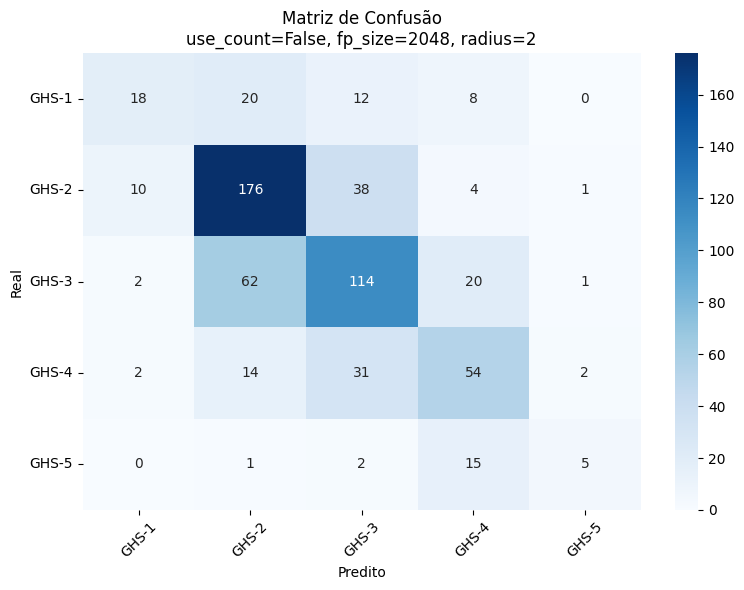

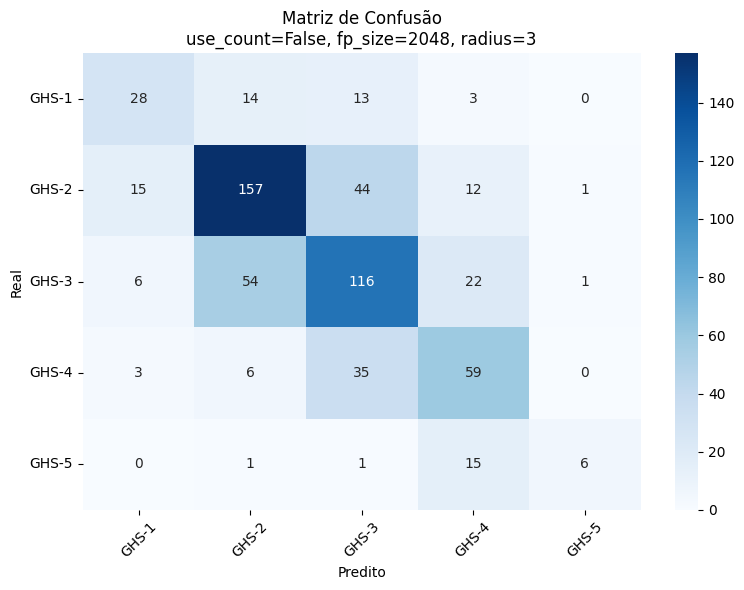

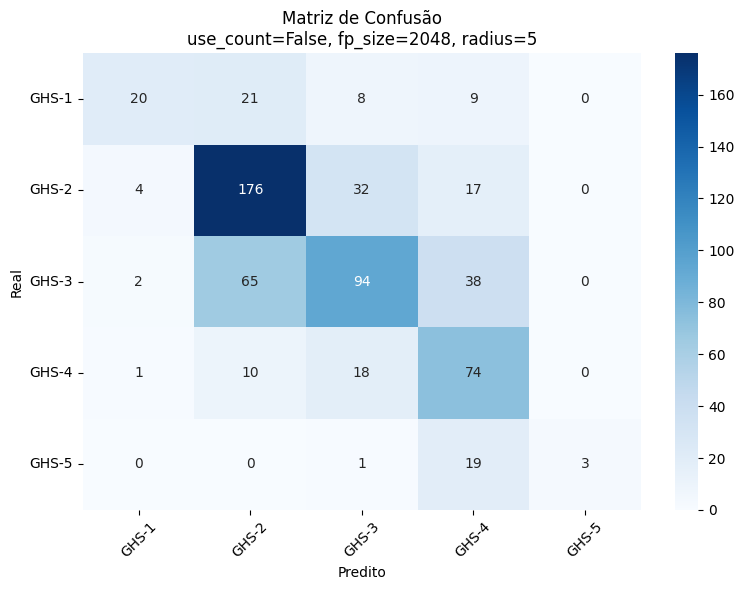

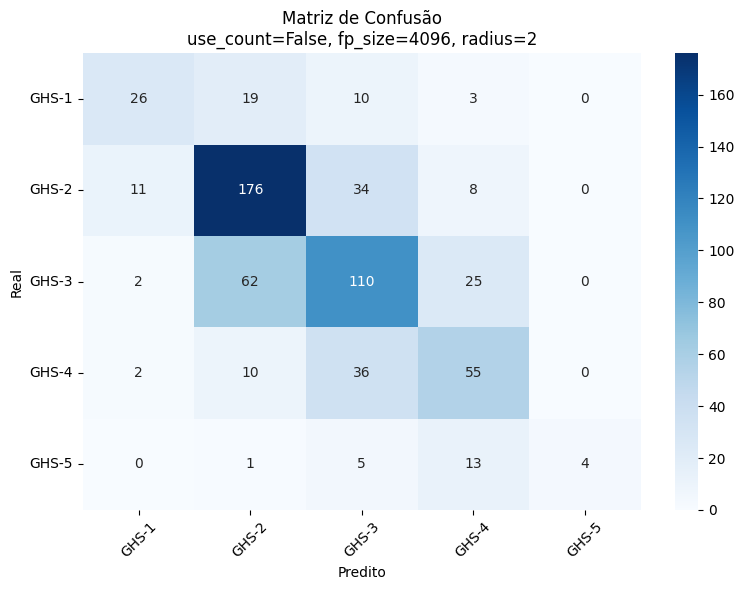

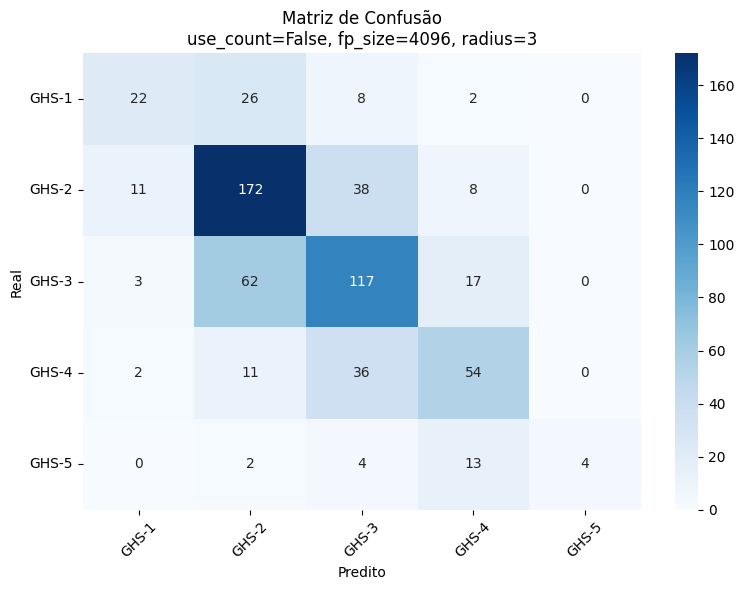

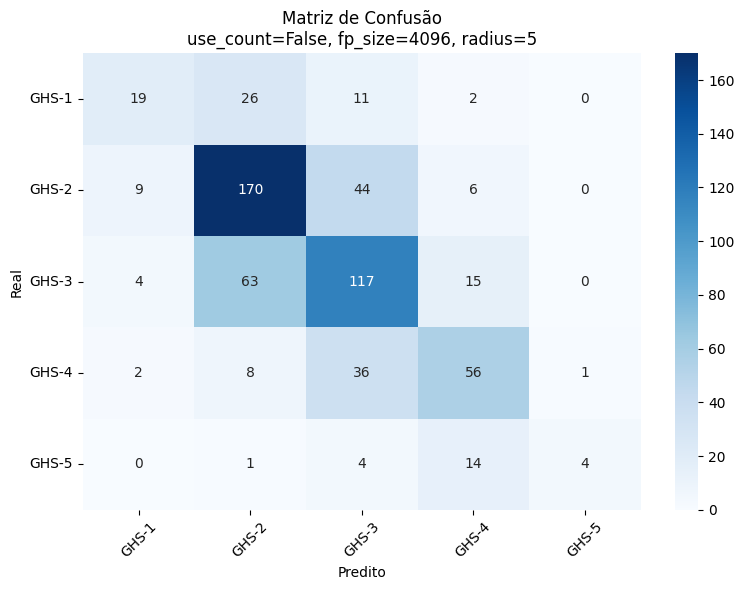

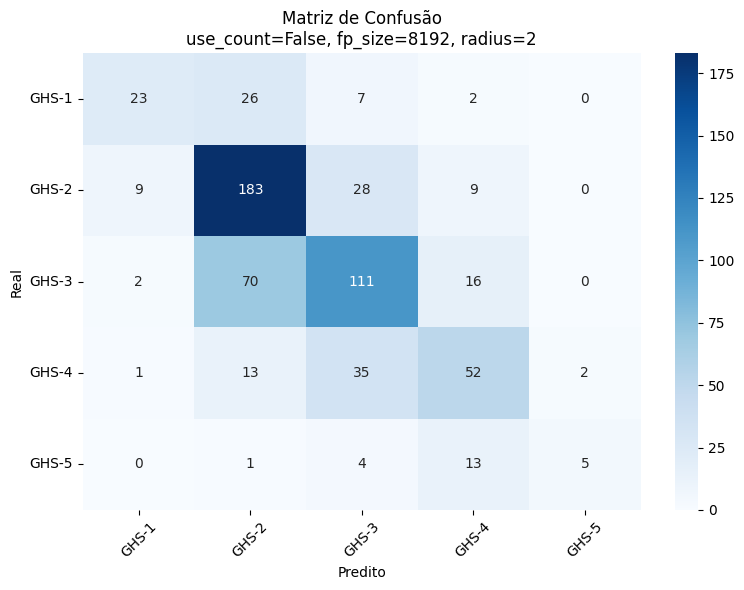

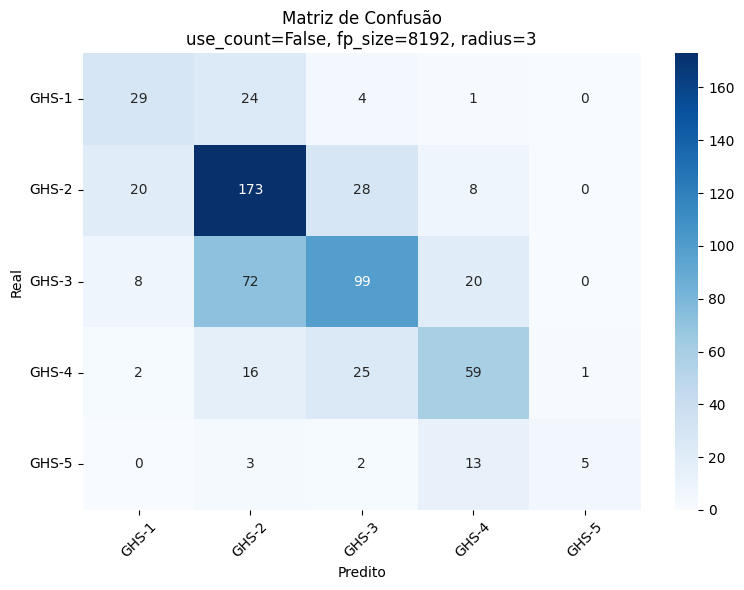

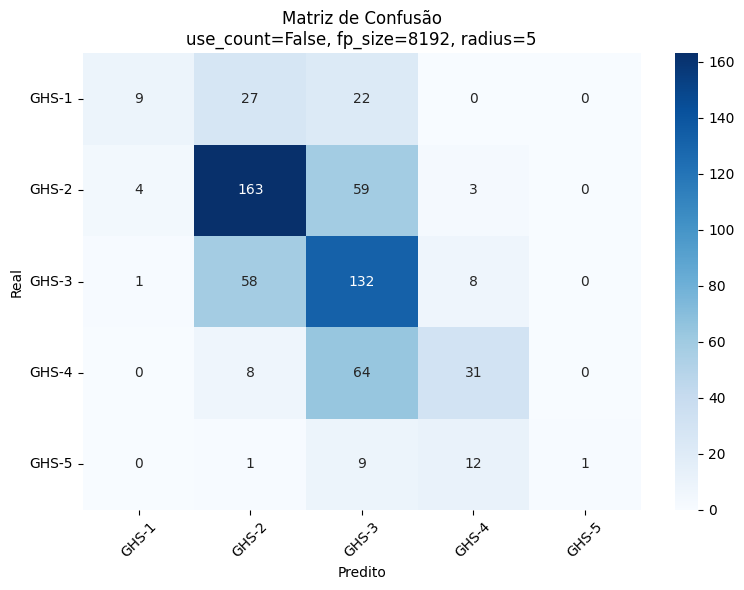

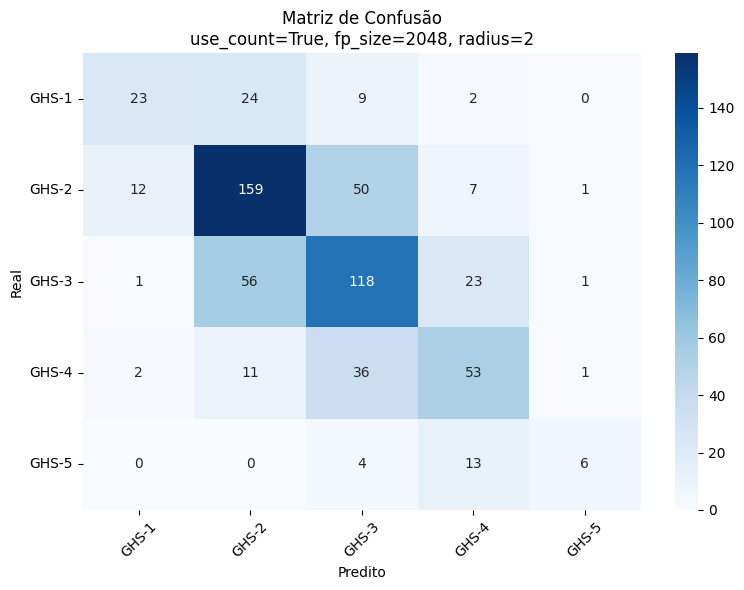

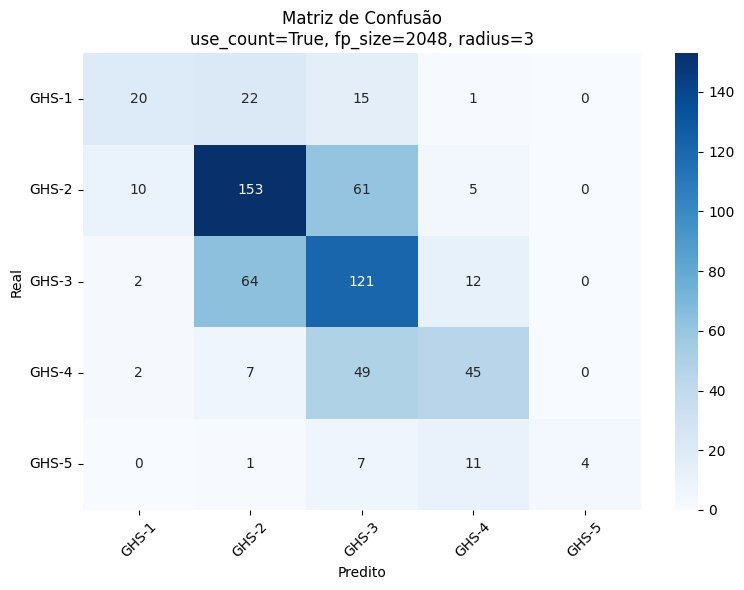

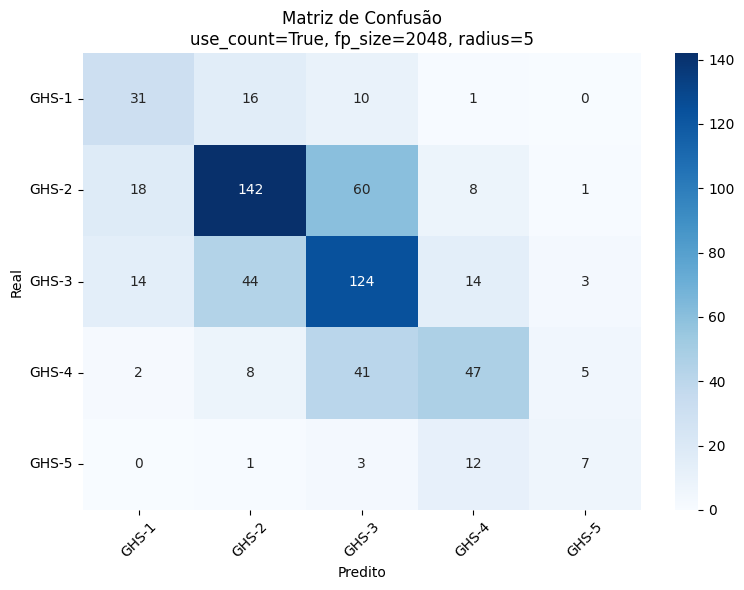

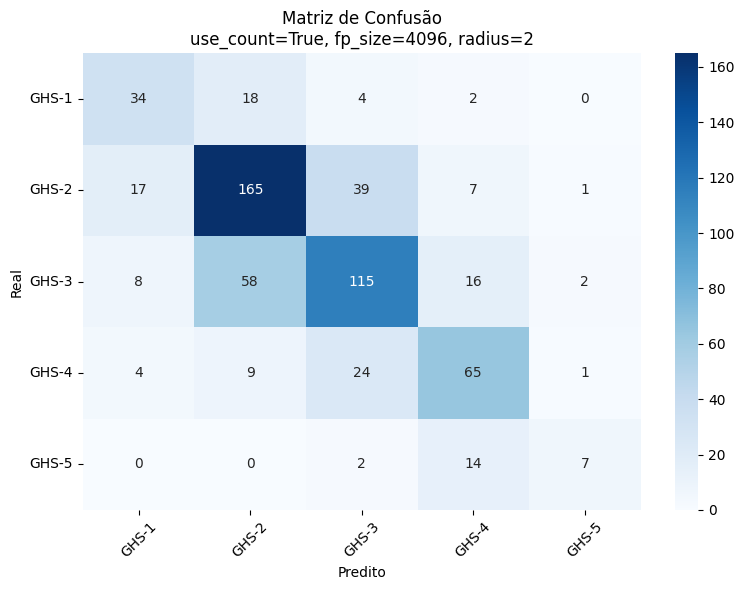

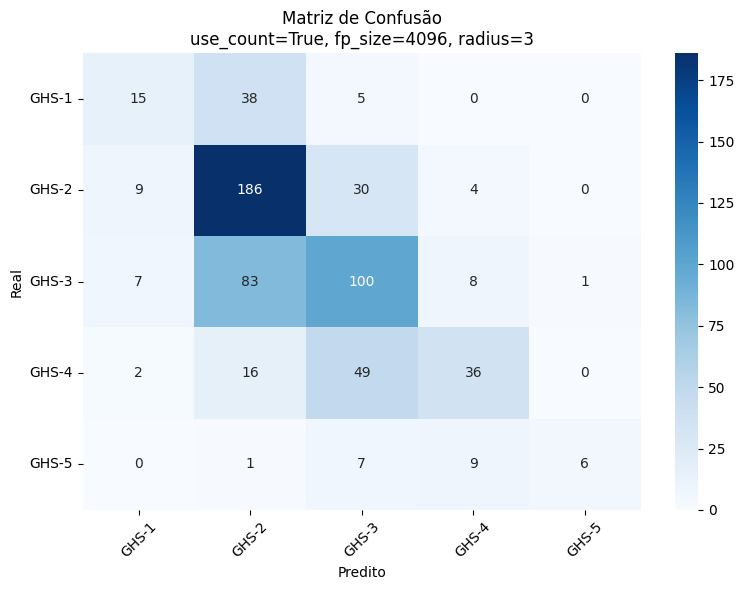

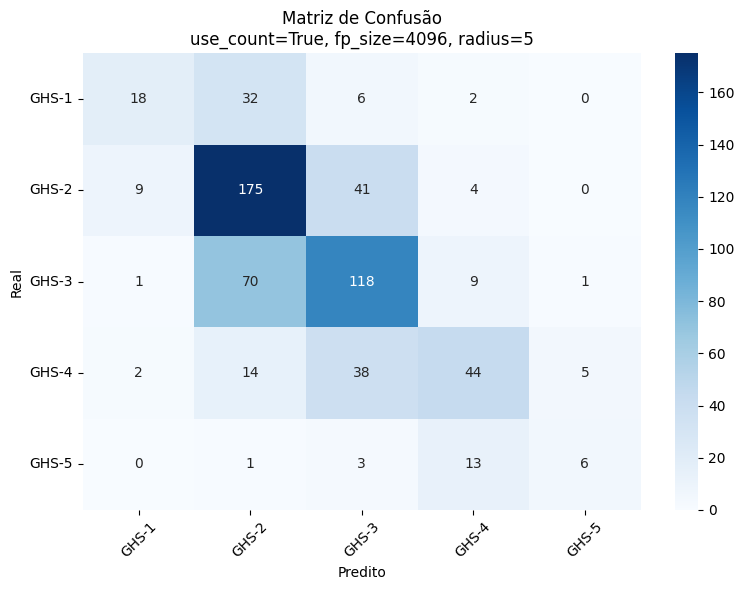

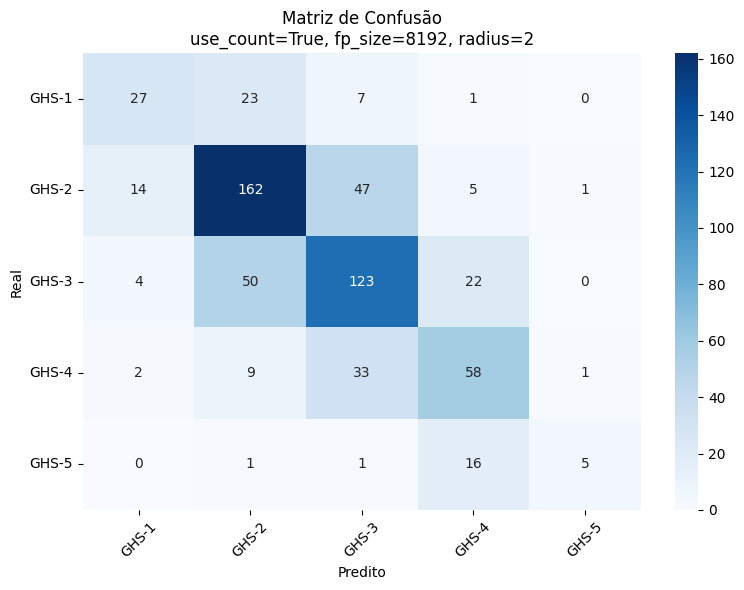

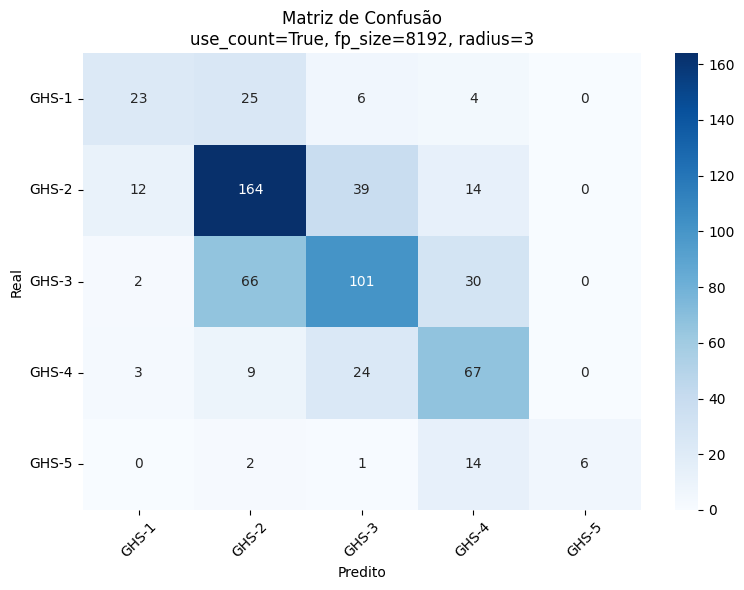

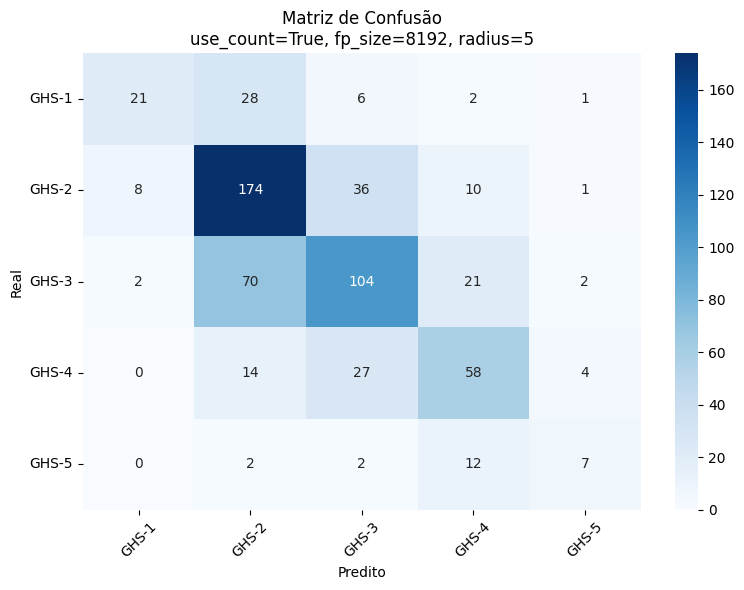

In [9]:
import os

# Geração e salvamento das matrizes de confusão
for r in resultados:
    try:
        use_count = r["use_count"]
        fp_size = r["fp_size"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        # Criação do diretório de saída
        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        # Definição do nome do arquivo
        file_name = f"confusion_uc-{use_count}_fp-{fp_size}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        # Geração da matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes
        )
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fp_size={fp_size}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fp_size}, r={radius}")
        print(e)

In [10]:
# Análise final dos resultados
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")


Ranking de combinações por acurácia:
    use_count  fp_size  radius  accuracy
12       True     4096       2  0.630719
15       True     8192       2  0.612745
6       False     8192       2  0.611111
3       False     4096       2  0.606209
4       False     4096       3  0.602941
0       False     2048       2  0.599673
2       False     2048       5  0.599673
5       False     4096       5  0.598039
1       False     2048       3  0.598039
7       False     8192       3  0.596405
17       True     8192       5  0.594771
14       True     4096       5  0.589869
16       True     8192       3  0.589869
9        True     2048       2  0.586601
11       True     2048       5  0.573529
10       True     2048       3  0.560458
13       True     4096       3  0.560458
8       False     8192       5  0.549020


In [11]:
# Salvamento dos resultados quantitativos
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Definição do caminho do arquivo de saída
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salvamento do DataFrame com métricas de performance
resultados_df.to_csv(csv_path, index=False)

# Análise de toxicidade oral em ratos

--- Mapeando categorias GHS para softmax ---

Testando: use_count=False, fp_size=2048, radius=2


[19:46:39] WARNING: not removing hydrogen atom without neighbors
[19:46:39] WARNING: not removing hydrogen atom without neighbors
[19:46:39] WARNING: not removing hydrogen atom without neighbors
[19:46:39] WARNING: not removing hydrogen atom without neighbors
[19:46:39] WARNING: not removing hydrogen atom without neighbors
[19:46:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:46:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:46:40] WARNING: not removing hydrogen atom without neighbors
[19:46:40] WARNING: not removing hydrogen atom without neighbors
[19:46:40] Unusual charge on atom 53 number of radical electrons set to zero
[19:46:40] Unusual charge on atom 9 number of radical electrons set to zero
[19:46:40] WARNING: not removing hydrogen atom without neighbors
[19:46:40] Unusual charge on atom 4 number of radical electrons set to zero
[19:46:40] WARNING: not removing hydrogen atom without neighbors
[19:46:40] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 1ms/step
Acurácia: 0.5459636024265049

Testando: use_count=False, fp_size=2048, radius=3


[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:46:47] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] Unusual charge on atom 53 number of radical electrons set to zero
[19:46:47] Unusual charge on atom 9 number of radical electrons set to zero
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] Unusual charge on atom 4 number of radical electrons set to zero
[19:46:47] WARNING: not removing hydrogen atom without neighbors
[19:46:47] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 1ms/step
Acurácia: 0.5305646290247317

Testando: use_count=False, fp_size=2048, radius=5


[19:46:55] WARNING: not removing hydrogen atom without neighbors
[19:46:55] WARNING: not removing hydrogen atom without neighbors
[19:46:55] WARNING: not removing hydrogen atom without neighbors
[19:46:55] WARNING: not removing hydrogen atom without neighbors
[19:46:55] WARNING: not removing hydrogen atom without neighbors
[19:46:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:46:55] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:46:56] WARNING: not removing hydrogen atom without neighbors
[19:46:56] WARNING: not removing hydrogen atom without neighbors
[19:46:56] Unusual charge on atom 53 number of radical electrons set to zero
[19:46:56] Unusual charge on atom 9 number of radical electrons set to zero
[19:46:56] WARNING: not removing hydrogen atom without neighbors
[19:46:56] Unusual charge on atom 4 number of radical electrons set to zero
[19:46:56] WARNING: not removing hydrogen atom without neighbors
[19:46:56] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 1ms/step
Acurácia: 0.5417638824078395

Testando: use_count=False, fp_size=4096, radius=2


[19:47:03] WARNING: not removing hydrogen atom without neighbors
[19:47:03] WARNING: not removing hydrogen atom without neighbors
[19:47:03] WARNING: not removing hydrogen atom without neighbors
[19:47:03] WARNING: not removing hydrogen atom without neighbors
[19:47:03] WARNING: not removing hydrogen atom without neighbors
[19:47:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:47:03] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:47:04] WARNING: not removing hydrogen atom without neighbors
[19:47:04] WARNING: not removing hydrogen atom without neighbors
[19:47:04] Unusual charge on atom 53 number of radical electrons set to zero
[19:47:04] Unusual charge on atom 9 number of radical electrons set to zero
[19:47:04] WARNING: not removing hydrogen atom without neighbors
[19:47:04] Unusual charge on atom 4 number of radical electrons set to zero
[19:47:04] WARNING: not removing hydrogen atom without neighbors
[19:47:04] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5417638824078395

Testando: use_count=False, fp_size=4096, radius=3


[19:47:12] WARNING: not removing hydrogen atom without neighbors
[19:47:12] WARNING: not removing hydrogen atom without neighbors
[19:47:12] WARNING: not removing hydrogen atom without neighbors
[19:47:12] WARNING: not removing hydrogen atom without neighbors
[19:47:12] WARNING: not removing hydrogen atom without neighbors
[19:47:12] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:47:13] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:47:13] WARNING: not removing hydrogen atom without neighbors
[19:47:13] WARNING: not removing hydrogen atom without neighbors
[19:47:13] Unusual charge on atom 53 number of radical electrons set to zero
[19:47:13] Unusual charge on atom 9 number of radical electrons set to zero
[19:47:13] WARNING: not removing hydrogen atom without neighbors
[19:47:13] Unusual charge on atom 4 number of radical electrons set to zero
[19:47:13] WARNING: not removing hydrogen atom without neighbors
[19:47:13] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5356976201586561

Testando: use_count=False, fp_size=4096, radius=5


[19:47:21] WARNING: not removing hydrogen atom without neighbors
[19:47:21] WARNING: not removing hydrogen atom without neighbors
[19:47:21] WARNING: not removing hydrogen atom without neighbors
[19:47:21] WARNING: not removing hydrogen atom without neighbors
[19:47:21] WARNING: not removing hydrogen atom without neighbors
[19:47:22] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:47:22] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:47:22] WARNING: not removing hydrogen atom without neighbors
[19:47:22] WARNING: not removing hydrogen atom without neighbors
[19:47:22] Unusual charge on atom 53 number of radical electrons set to zero
[19:47:22] Unusual charge on atom 9 number of radical electrons set to zero
[19:47:22] WARNING: not removing hydrogen atom without neighbors
[19:47:22] Unusual charge on atom 4 number of radical electrons set to zero
[19:47:22] WARNING: not removing hydrogen atom without neighbors
[19:47:22] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 1ms/step
Acurácia: 0.5300979934671022

Testando: use_count=False, fp_size=8192, radius=2


[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:47:31] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] Unusual charge on atom 53 number of radical electrons set to zero
[19:47:31] Unusual charge on atom 9 number of radical electrons set to zero
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] Unusual charge on atom 4 number of radical electrons set to zero
[19:47:31] WARNING: not removing hydrogen atom without neighbors
[19:47:31] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.54129724685021

Testando: use_count=False, fp_size=8192, radius=3


[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:47:45] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] WARNING: not removing hydrogen atom without neighbors
[19:47:45] Unusual charge on atom 53 number of radical electrons set to zero
[19:47:46] Unusual charge on atom 9 number of radical electrons set to zero
[19:47:46] WARNING: not removing hydrogen atom without neighbors
[19:47:46] Unusual charge on atom 4 number of radical electrons set to zero
[19:47:46] WARNING: not removing hydrogen atom without neighbors
[19:47:46] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5506299580027998

Testando: use_count=False, fp_size=8192, radius=5


[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:48:00] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:00] WARNING: not removing hydrogen atom without neighbors
[19:48:01] Unusual charge on atom 53 number of radical electrons set to zero
[19:48:01] Unusual charge on atom 9 number of radical electrons set to zero
[19:48:01] WARNING: not removing hydrogen atom without neighbors
[19:48:01] Unusual charge on atom 4 number of radical electrons set to zero
[19:48:01] WARNING: not removing hydrogen atom without neighbors
[19:48:01] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5333644423705086

Testando: use_count=True, fp_size=2048, radius=2


[19:48:14] WARNING: not removing hydrogen atom without neighbors
[19:48:14] WARNING: not removing hydrogen atom without neighbors
[19:48:14] WARNING: not removing hydrogen atom without neighbors
[19:48:14] WARNING: not removing hydrogen atom without neighbors
[19:48:14] WARNING: not removing hydrogen atom without neighbors
[19:48:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:48:14] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:48:15] WARNING: not removing hydrogen atom without neighbors
[19:48:15] WARNING: not removing hydrogen atom without neighbors
[19:48:15] Unusual charge on atom 53 number of radical electrons set to zero
[19:48:15] Unusual charge on atom 9 number of radical electrons set to zero
[19:48:15] WARNING: not removing hydrogen atom without neighbors
[19:48:15] Unusual charge on atom 4 number of radical electrons set to zero
[19:48:15] WARNING: not removing hydrogen atom without neighbors
[19:48:15] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 1ms/step
Acurácia: 0.5548296780214652

Testando: use_count=True, fp_size=2048, radius=3


[19:48:22] WARNING: not removing hydrogen atom without neighbors
[19:48:22] WARNING: not removing hydrogen atom without neighbors
[19:48:22] WARNING: not removing hydrogen atom without neighbors
[19:48:22] WARNING: not removing hydrogen atom without neighbors
[19:48:22] WARNING: not removing hydrogen atom without neighbors
[19:48:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:48:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:48:23] WARNING: not removing hydrogen atom without neighbors
[19:48:23] WARNING: not removing hydrogen atom without neighbors
[19:48:23] Unusual charge on atom 53 number of radical electrons set to zero
[19:48:23] Unusual charge on atom 9 number of radical electrons set to zero
[19:48:23] WARNING: not removing hydrogen atom without neighbors
[19:48:23] Unusual charge on atom 4 number of radical electrons set to zero
[19:48:23] WARNING: not removing hydrogen atom without neighbors
[19:48:23] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 1ms/step
Acurácia: 0.5478301446570228

Testando: use_count=True, fp_size=2048, radius=5


[19:48:30] WARNING: not removing hydrogen atom without neighbors
[19:48:30] WARNING: not removing hydrogen atom without neighbors
[19:48:30] WARNING: not removing hydrogen atom without neighbors
[19:48:30] WARNING: not removing hydrogen atom without neighbors
[19:48:30] WARNING: not removing hydrogen atom without neighbors
[19:48:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:48:30] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:48:31] WARNING: not removing hydrogen atom without neighbors
[19:48:31] WARNING: not removing hydrogen atom without neighbors
[19:48:31] Unusual charge on atom 53 number of radical electrons set to zero
[19:48:31] Unusual charge on atom 9 number of radical electrons set to zero
[19:48:31] WARNING: not removing hydrogen atom without neighbors
[19:48:31] Unusual charge on atom 4 number of radical electrons set to zero
[19:48:31] WARNING: not removing hydrogen atom without neighbors
[19:48:31] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5487634157722818

Testando: use_count=True, fp_size=4096, radius=2


[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:48:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] Unusual charge on atom 53 number of radical electrons set to zero
[19:48:39] Unusual charge on atom 9 number of radical electrons set to zero
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] Unusual charge on atom 4 number of radical electrons set to zero
[19:48:39] WARNING: not removing hydrogen atom without neighbors
[19:48:39] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.565095660289314

Testando: use_count=True, fp_size=4096, radius=3


[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:48:49] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] WARNING: not removing hydrogen atom without neighbors
[19:48:49] Unusual charge on atom 53 number of radical electrons set to zero
[19:48:50] Unusual charge on atom 9 number of radical electrons set to zero
[19:48:50] WARNING: not removing hydrogen atom without neighbors
[19:48:50] Unusual charge on atom 4 number of radical electrons set to zero
[19:48:50] WARNING: not removing hydrogen atom without neighbors
[19:48:50] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5557629491367242

Testando: use_count=True, fp_size=4096, radius=5


[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:49:00] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] WARNING: not removing hydrogen atom without neighbors
[19:49:00] Unusual charge on atom 53 number of radical electrons set to zero
[19:49:01] Unusual charge on atom 9 number of radical electrons set to zero
[19:49:01] WARNING: not removing hydrogen atom without neighbors
[19:49:01] Unusual charge on atom 4 number of radical electrons set to zero
[19:49:01] WARNING: not removing hydrogen atom without neighbors
[19:49:01] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5571628558096127

Testando: use_count=True, fp_size=8192, radius=2


[19:49:13] WARNING: not removing hydrogen atom without neighbors
[19:49:13] WARNING: not removing hydrogen atom without neighbors
[19:49:13] WARNING: not removing hydrogen atom without neighbors
[19:49:13] WARNING: not removing hydrogen atom without neighbors
[19:49:13] WARNING: not removing hydrogen atom without neighbors
[19:49:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:49:14] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:49:14] WARNING: not removing hydrogen atom without neighbors
[19:49:14] WARNING: not removing hydrogen atom without neighbors
[19:49:14] Unusual charge on atom 53 number of radical electrons set to zero
[19:49:14] Unusual charge on atom 9 number of radical electrons set to zero
[19:49:14] WARNING: not removing hydrogen atom without neighbors
[19:49:14] Unusual charge on atom 4 number of radical electrons set to zero
[19:49:14] WARNING: not removing hydrogen atom without neighbors
[19:49:14] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5538964069062062

Testando: use_count=True, fp_size=8192, radius=3


[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:49:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] Unusual charge on atom 53 number of radical electrons set to zero
[19:49:29] Unusual charge on atom 9 number of radical electrons set to zero
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] Unusual charge on atom 4 number of radical electrons set to zero
[19:49:29] WARNING: not removing hydrogen atom without neighbors
[19:49:29] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 3ms/step
Acurácia: 0.5501633224451703

Testando: use_count=True, fp_size=8192, radius=5


[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:49:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] WARNING: not removing hydrogen atom without neighbors
[19:49:43] Unusual charge on atom 53 number of radical electrons set to zero
[19:49:44] Unusual charge on atom 9 number of radical electrons set to zero
[19:49:44] WARNING: not removing hydrogen atom without neighbors
[19:49:44] Unusual charge on atom 4 number of radical electrons set to zero
[19:49:44] WARNING: not removing hydrogen atom without neighbors
[19:49:44] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 2ms/step
Acurácia: 0.5627624825011666


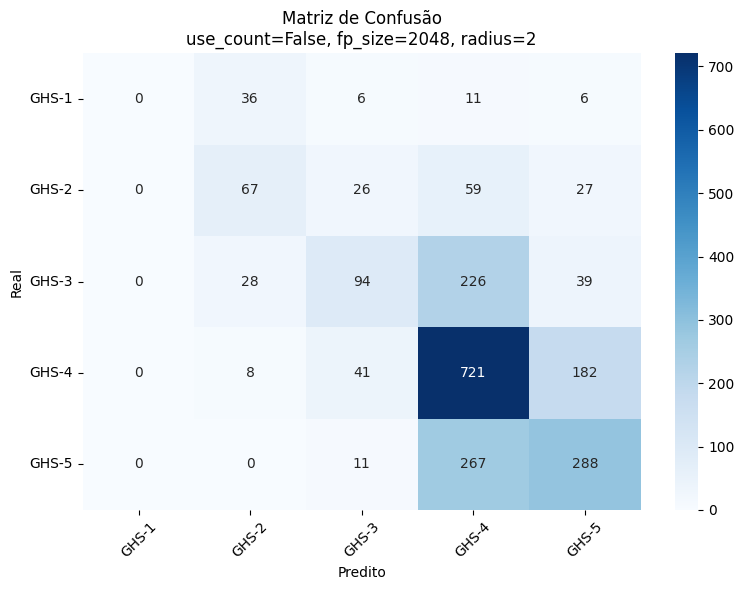

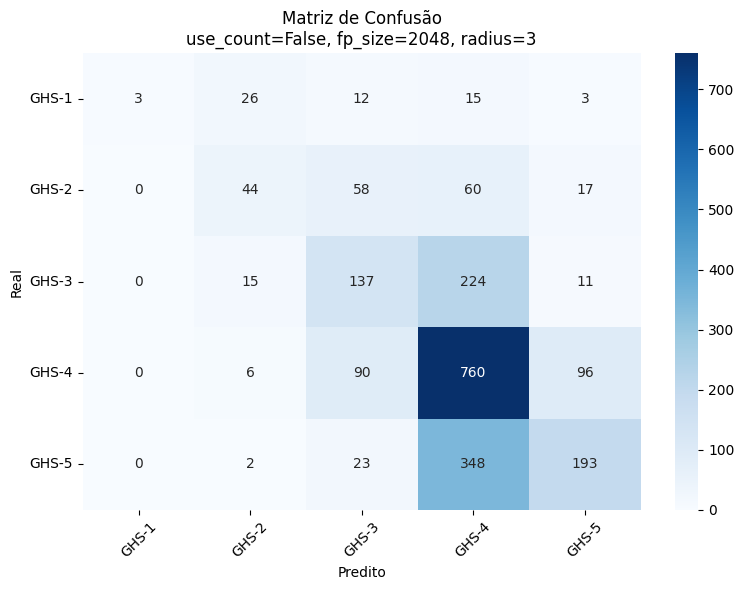

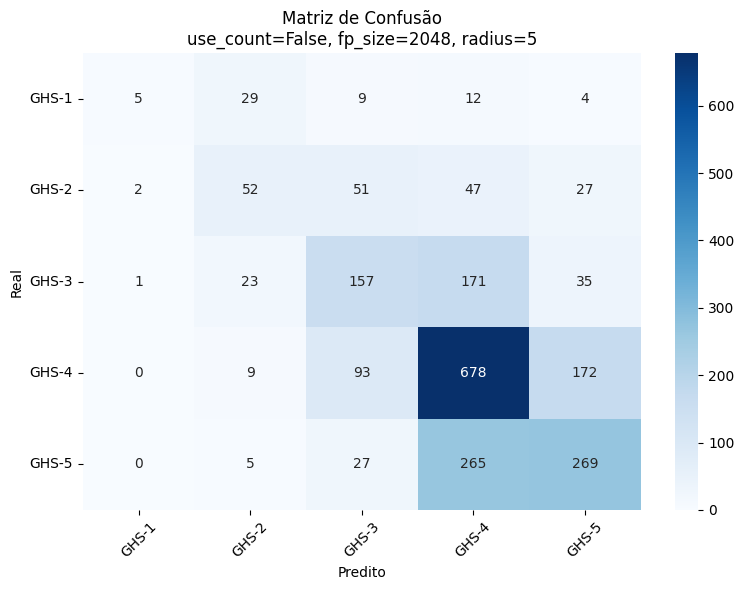

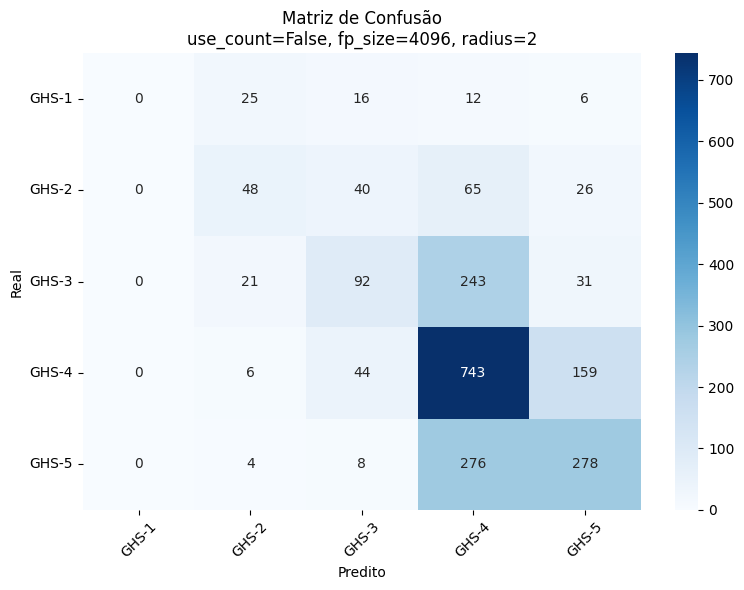

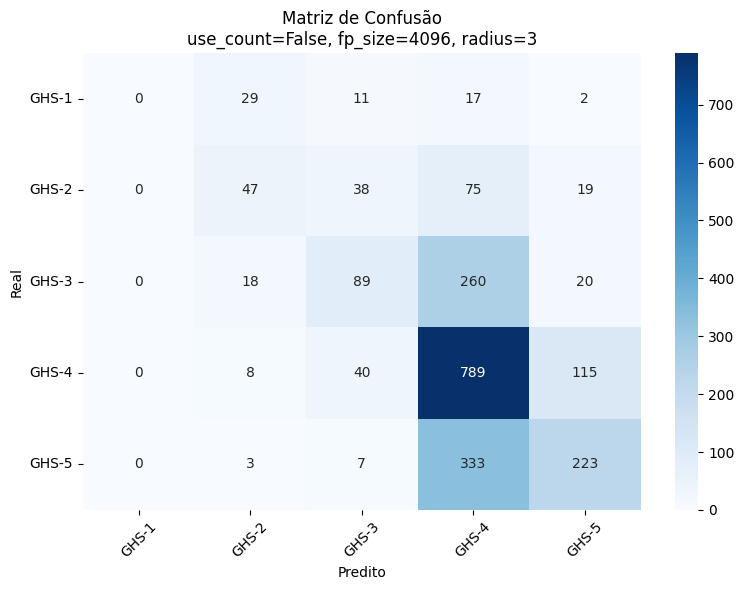

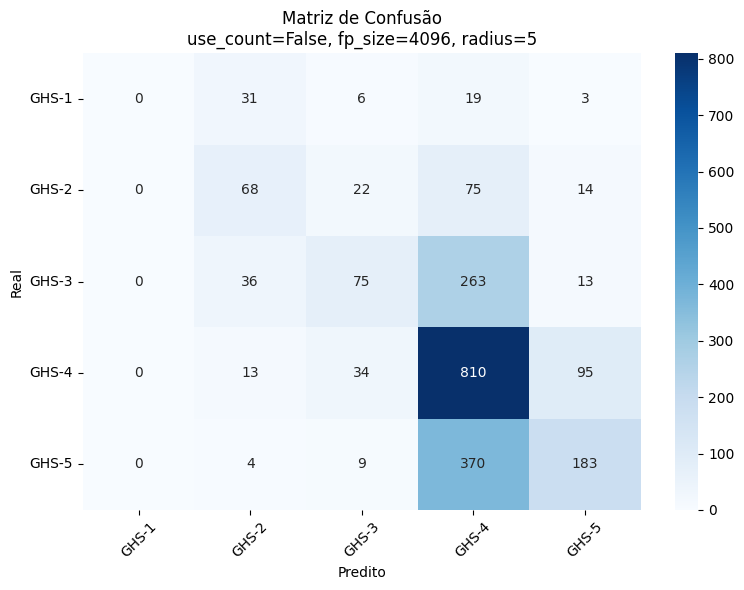

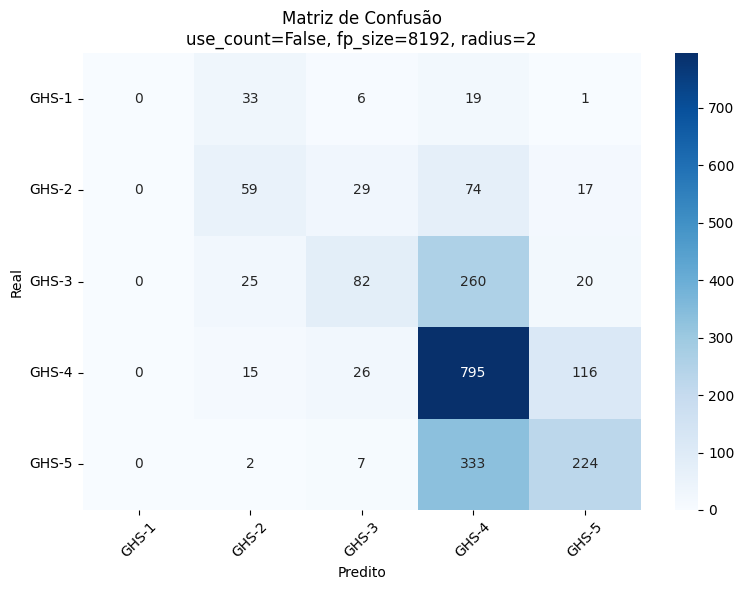

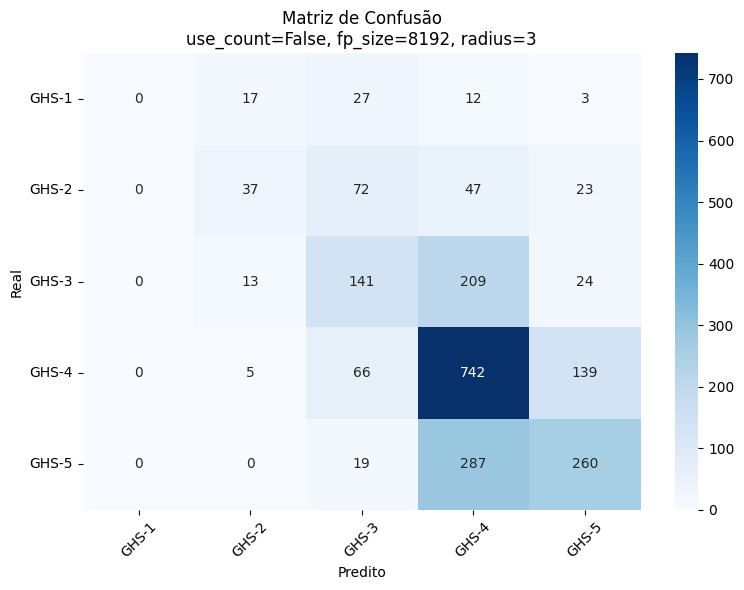

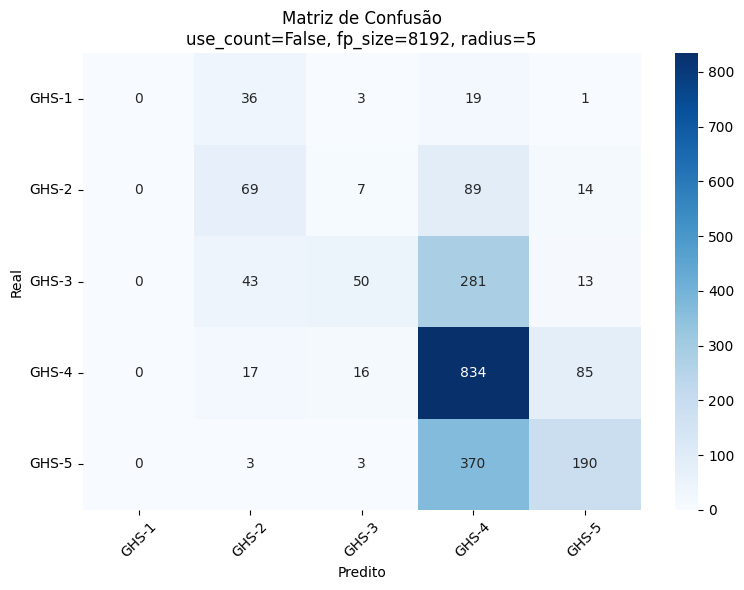

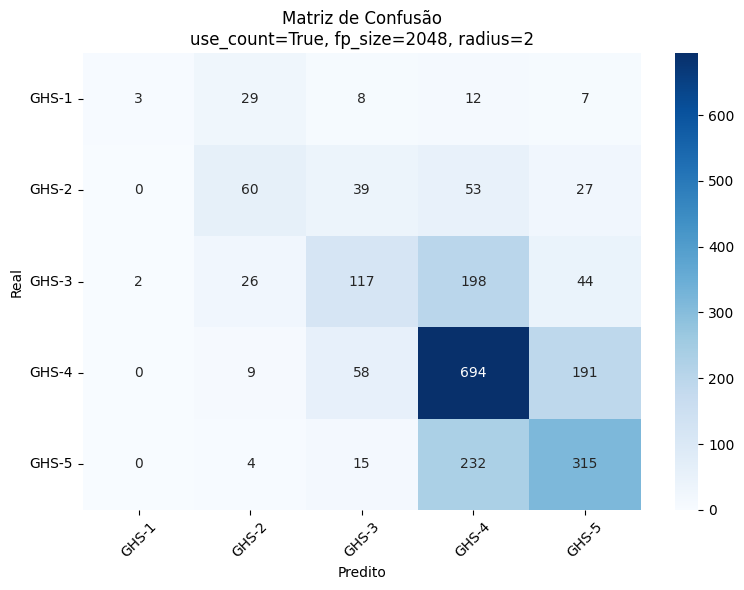

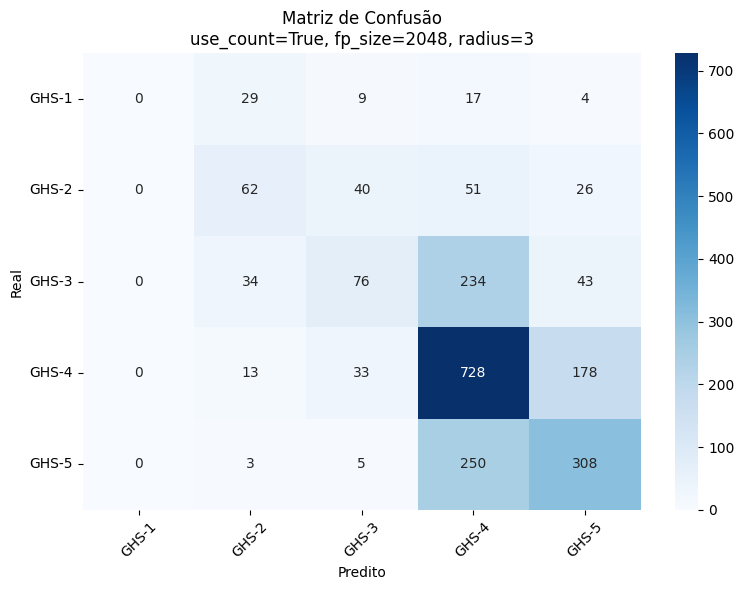

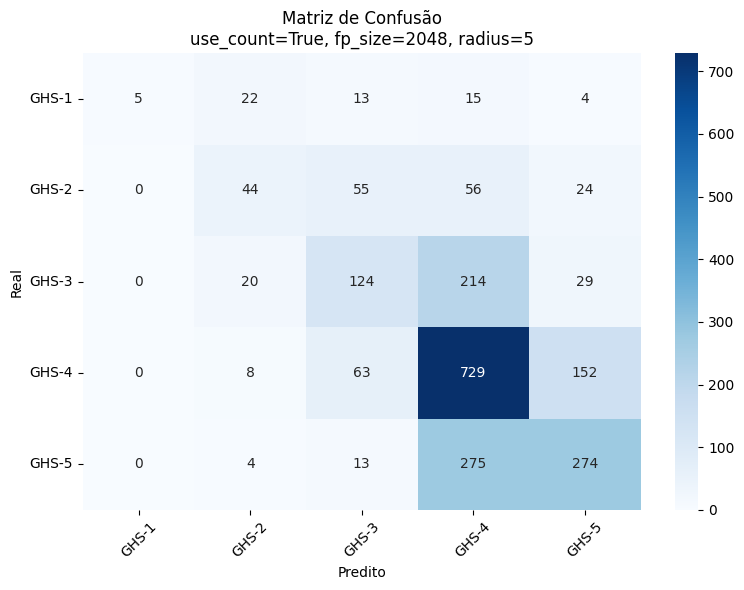

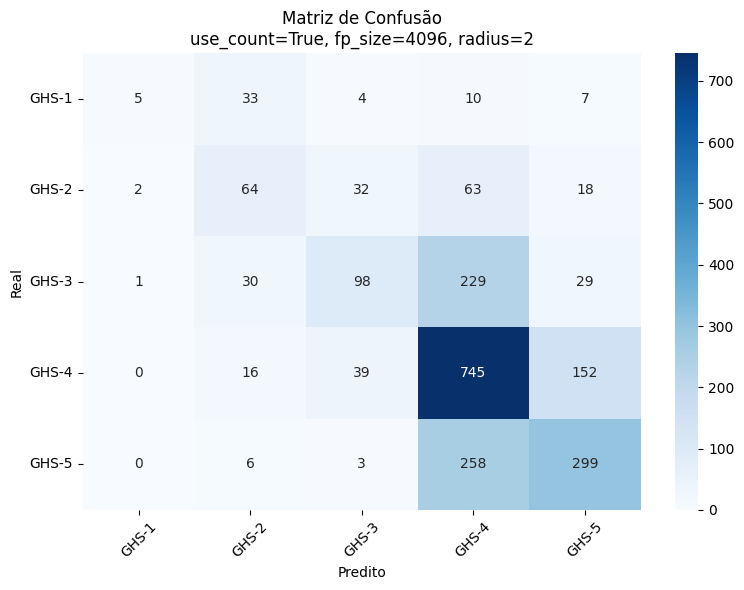

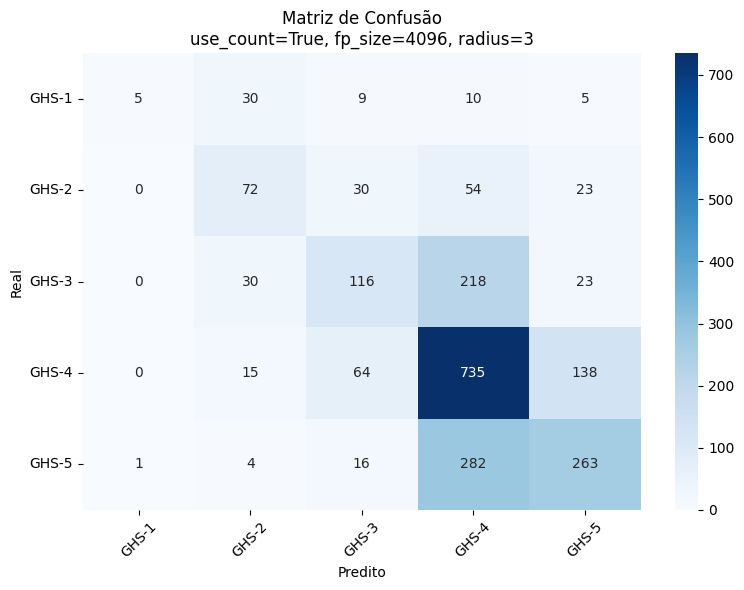

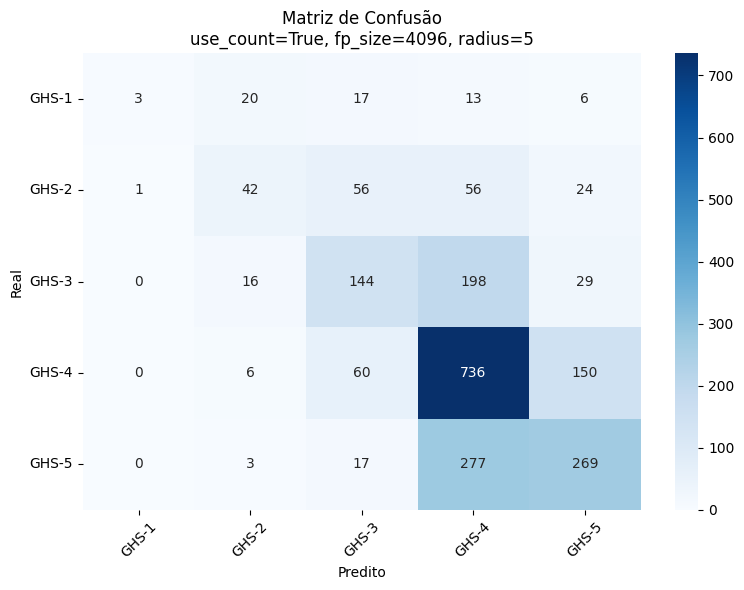

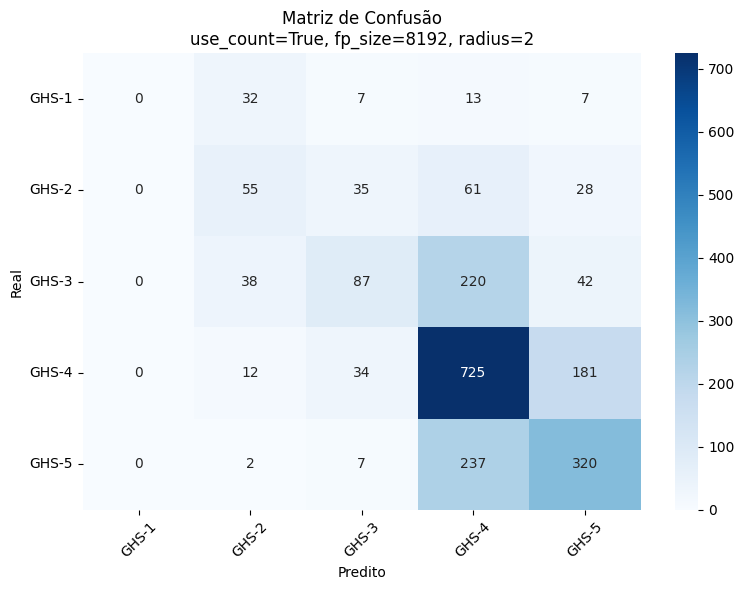

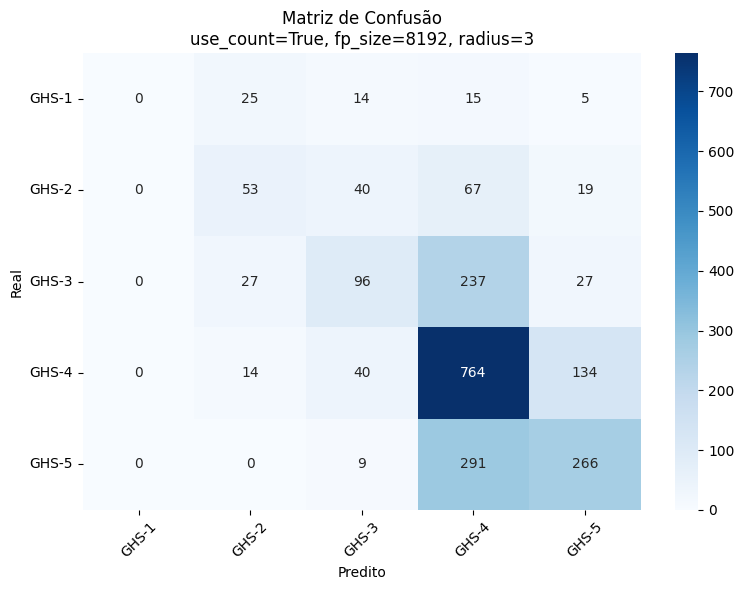

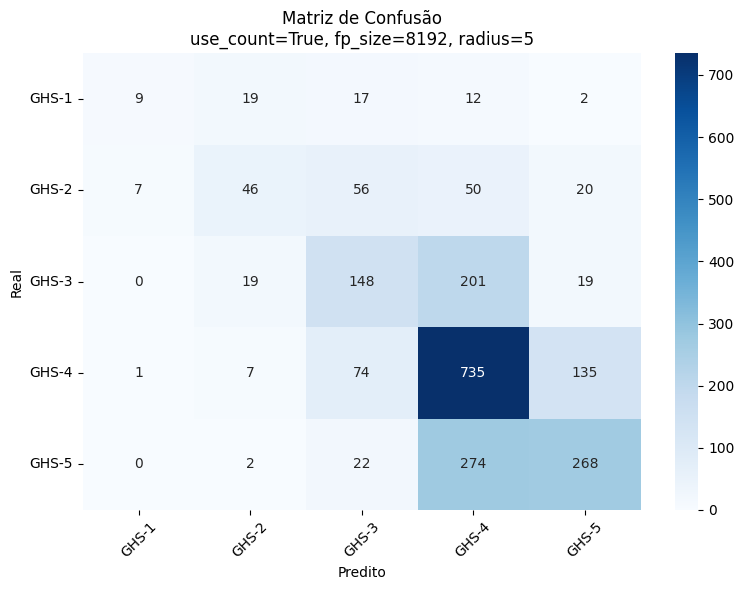


Ranking de combinações por acurácia:
    use_count  fp_size  radius  accuracy
12       True     4096       2  0.565096
17       True     8192       5  0.562762
14       True     4096       5  0.557163
13       True     4096       3  0.555763
9        True     2048       2  0.554830
15       True     8192       2  0.553896
7       False     8192       3  0.550630
16       True     8192       3  0.550163
11       True     2048       5  0.548763
10       True     2048       3  0.547830
0       False     2048       2  0.545964
3       False     4096       2  0.541764
2       False     2048       5  0.541764
6       False     8192       2  0.541297
4       False     4096       3  0.535698
8       False     8192       5  0.533364
1       False     2048       3  0.530565
5       False     4096       5  0.530098


In [13]:
# Configurações do experimento
arquivo_classificado = "rat_vo_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]  
exibir_plot = True  

# Carregamento e pré-processamento dos dados
df = pd.read_csv(arquivo_classificado)

print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1

classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

# Inicialização da lista para armazenar resultados
resultados = []

# Loop de grid
for use_count in use_count_option:
    for fp_size in fp_size_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fp_size={fp_size}, radius={radius}")

            try: 
                # Geração de fingerprints
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fp_size=fp_size,
                    use_count=use_count
                )

                # Remove moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Definição das variáveis X e y
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

                # Construção do modelo
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # Evitar overfitting
                early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

                # Treinamento do Modelo
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stop], verbose=0)
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Salva os dados para plot posterior
                resultados.append({
                    "use_count": use_count,
                    "fp_size": fp_size,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fp_size={fp_size}, radius={radius}")
                print(e)

# === GERAÇÃO E SALVAMENTO DOS PLOTS ===
for r in resultados:
    try:
        use_count = r["use_count"]
        fp_size = r["fp_size"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"confusion_uc-{use_count}_fp-{fp_size}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fp_size={fp_size}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fp_size}, r={radius}")
        print(e)

# === RANKING FINAL ===
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")

# Cria diretório de resultados, se ainda não existir
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Caminho completo do arquivo CSV
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salva o DataFrame (sem colunas de y_test/y_pred, pois são grandes arrays)
resultados_df.to_csv(csv_path, index=False)


# Análise de toxicidade oral em camundongos

--- Mapeando categorias GHS para softmax ---

Testando: use_count=False, fp_size=2048, radius=2


[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:22] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:22] WARNING: not removing hydrogen atom without neighbors
[19:53:23] WARNING: not removing hydrogen atom without neighbors
[19:53:23] WARNING: not removing hydrogen atom without neighbors
[19:53:23] WARNING: not removing hydrogen atom without neighbors
[19:53:24] Unusual charge on atom 9 number of radical electrons set to zero
[19:53:24] Unusual charge on atom 4 number of radical electrons set to zero
[19:53:24] WARNING: not removing hydrogen atom without neighbors
[19:53:24] WARNING: not removing hydrogen atom without neighbors
[19:53:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6963093835885356

Testando: use_count=False, fp_size=2048, radius=3


[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:42] WARNING: not removing hydrogen atom without neighbors
[19:53:43] WARNING: not removing hydrogen atom without neighbors
[19:53:43] WARNING: not removing hydrogen atom without neighbors
[19:53:43] WARNING: not removing hydrogen atom without neighbors
[19:53:43] Unusual charge on atom 9 number of radical electrons set to zero
[19:53:43] Unusual charge on atom 4 number of radical electrons set to zero
[19:53:43] WARNING: not removing hydrogen atom without neighbors
[19:53:44] WARNING: not removing hydrogen atom without neighbors
[19:53:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6923831959167648

Testando: use_count=False, fp_size=2048, radius=5


[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:01] WARNING: not removing hydrogen atom without neighbors
[19:54:02] Unusual charge on atom 9 number of radical electrons set to zero
[19:54:02] Unusual charge on atom 4 number of radical electrons set to zero
[19:54:02] WARNING: not removing hydrogen atom without neighbors
[19:54:02] WARNING: not removing hydrogen atom without neighbors
[19:54:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6872791519434629

Testando: use_count=False, fp_size=4096, radius=2


[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:19] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:19] WARNING: not removing hydrogen atom without neighbors
[19:54:20] WARNING: not removing hydrogen atom without neighbors
[19:54:20] WARNING: not removing hydrogen atom without neighbors
[19:54:20] WARNING: not removing hydrogen atom without neighbors
[19:54:21] Unusual charge on atom 9 number of radical electrons set to zero
[19:54:21] Unusual charge on atom 4 number of radical electrons set to zero
[19:54:21] WARNING: not removing hydrogen atom without neighbors
[19:54:21] WARNING: not removing hydrogen atom without neighbors
[19:54:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6998429524931292

Testando: use_count=False, fp_size=4096, radius=3


[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:43] WARNING: not removing hydrogen atom without neighbors
[19:54:44] Unusual charge on atom 9 number of radical electrons set to zero
[19:54:44] Unusual charge on atom 4 number of radical electrons set to zero
[19:54:44] WARNING: not removing hydrogen atom without neighbors
[19:54:44] WARNING: not removing hydrogen atom without neighbors
[19:54:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.7021986650961916

Testando: use_count=False, fp_size=4096, radius=5


[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:07] WARNING: not removing hydrogen atom without neighbors
[19:55:08] Unusual charge on atom 9 number of radical electrons set to zero
[19:55:08] Unusual charge on atom 4 number of radical electrons set to zero
[19:55:08] WARNING: not removing hydrogen atom without neighbors
[19:55:08] WARNING: not removing hydrogen atom without neighbors
[19:55:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6976835492736553

Testando: use_count=False, fp_size=8192, radius=2


[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:30] WARNING: not removing hydrogen atom without neighbors
[19:55:31] WARNING: not removing hydrogen atom without neighbors
[19:55:31] Unusual charge on atom 9 number of radical electrons set to zero
[19:55:31] Unusual charge on atom 4 number of radical electrons set to zero
[19:55:31] WARNING: not removing hydrogen atom without neighbors
[19:55:31] WARNING: not removing hydrogen atom without neighbors
[19:55:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.7029839026305458

Testando: use_count=False, fp_size=8192, radius=3


[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:07] WARNING: not removing hydrogen atom without neighbors
[19:56:08] Unusual charge on atom 9 number of radical electrons set to zero
[19:56:08] Unusual charge on atom 4 number of radical electrons set to zero
[19:56:08] WARNING: not removing hydrogen atom without neighbors
[19:56:08] WARNING: not removing hydrogen atom without neighbors
[19:56:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.6968983117393012

Testando: use_count=False, fp_size=8192, radius=5


[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:40] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:40] WARNING: not removing hydrogen atom without neighbors
[19:56:41] WARNING: not removing hydrogen atom without neighbors
[19:56:41] WARNING: not removing hydrogen atom without neighbors
[19:56:41] WARNING: not removing hydrogen atom without neighbors
[19:56:41] Unusual charge on atom 9 number of radical electrons set to zero
[19:56:41] Unusual charge on atom 4 number of radical electrons set to zero
[19:56:41] WARNING: not removing hydrogen atom without neighbors
[19:56:41] WARNING: not removing hydrogen atom without neighbors
[19:56:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.704554377699254

Testando: use_count=True, fp_size=2048, radius=2


[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:17] WARNING: not removing hydrogen atom without neighbors
[19:57:18] WARNING: not removing hydrogen atom without neighbors
[19:57:18] Unusual charge on atom 9 number of radical electrons set to zero
[19:57:18] Unusual charge on atom 4 number of radical electrons set to zero
[19:57:18] WARNING: not removing hydrogen atom without neighbors
[19:57:18] WARNING: not removing hydrogen atom without neighbors
[19:57:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6953278366705928

Testando: use_count=True, fp_size=2048, radius=3


[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:37] WARNING: not removing hydrogen atom without neighbors
[19:57:38] Unusual charge on atom 9 number of radical electrons set to zero
[19:57:38] Unusual charge on atom 4 number of radical electrons set to zero
[19:57:38] WARNING: not removing hydrogen atom without neighbors
[19:57:38] WARNING: not removing hydrogen atom without neighbors
[19:57:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.7006281900274833

Testando: use_count=True, fp_size=2048, radius=5


[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:57] WARNING: not removing hydrogen atom without neighbors
[19:57:58] WARNING: not removing hydrogen atom without neighbors
[19:57:58] Unusual charge on atom 9 number of radical electrons set to zero
[19:57:58] Unusual charge on atom 4 number of radical electrons set to zero
[19:57:58] WARNING: not removing hydrogen atom without neighbors
[19:57:59] WARNING: not removing hydrogen atom without neighbors
[19:57:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.6914016489988222

Testando: use_count=True, fp_size=4096, radius=2


[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:16] WARNING: not removing hydrogen atom without neighbors
[19:58:17] WARNING: not removing hydrogen atom without neighbors
[19:58:17] WARNING: not removing hydrogen atom without neighbors
[19:58:17] WARNING: not removing hydrogen atom without neighbors
[19:58:17] Unusual charge on atom 9 number of radical electrons set to zero
[19:58:18] Unusual charge on atom 4 number of radical electrons set to zero
[19:58:18] WARNING: not removing hydrogen atom without neighbors
[19:58:18] WARNING: not removing hydrogen atom without neighbors
[19:58:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.7025912838633687

Testando: use_count=True, fp_size=4096, radius=3


[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:39] WARNING: not removing hydrogen atom without neighbors
[19:58:40] WARNING: not removing hydrogen atom without neighbors
[19:58:40] WARNING: not removing hydrogen atom without neighbors
[19:58:40] WARNING: not removing hydrogen atom without neighbors
[19:58:40] Unusual charge on atom 9 number of radical electrons set to zero
[19:58:40] Unusual charge on atom 4 number of radical electrons set to zero
[19:58:40] WARNING: not removing hydrogen atom without neighbors
[19:58:40] WARNING: not removing hydrogen atom without neighbors
[19:58:

160/160 [==============================] - 0s 1ms/step
Acurácia: 0.702002355712603

Testando: use_count=True, fp_size=4096, radius=5


[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:03] WARNING: not removing hydrogen atom without neighbors
[19:59:04] Unusual charge on atom 9 number of radical electrons set to zero
[19:59:04] Unusual charge on atom 4 number of radical electrons set to zero
[19:59:04] WARNING: not removing hydrogen atom without neighbors
[19:59:04] WARNING: not removing hydrogen atom without neighbors
[19:59:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.7029839026305458

Testando: use_count=True, fp_size=8192, radius=2


[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:27] WARNING: not removing hydrogen atom without neighbors
[19:59:28] WARNING: not removing hydrogen atom without neighbors
[19:59:28] Unusual charge on atom 9 number of radical electrons set to zero
[19:59:28] Unusual charge on atom 4 number of radical electrons set to zero
[19:59:28] WARNING: not removing hydrogen atom without neighbors
[19:59:28] WARNING: not removing hydrogen atom without neighbors
[19:59:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.7004318806438948

Testando: use_count=True, fp_size=8192, radius=3


[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:02] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:02] WARNING: not removing hydrogen atom without neighbors
[20:00:03] WARNING: not removing hydrogen atom without neighbors
[20:00:03] WARNING: not removing hydrogen atom without neighbors
[20:00:03] WARNING: not removing hydrogen atom without neighbors
[20:00:04] Unusual charge on atom 9 number of radical electrons set to zero
[20:00:04] Unusual charge on atom 4 number of radical electrons set to zero
[20:00:04] WARNING: not removing hydrogen atom without neighbors
[20:00:04] WARNING: not removing hydrogen atom without neighbors
[20:00:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.7108362779740872

Testando: use_count=True, fp_size=8192, radius=5


[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:39] WARNING: not removing hydrogen atom without neighbors
[20:00:40] WARNING: not removing hydrogen atom without neighbors
[20:00:40] WARNING: not removing hydrogen atom without neighbors
[20:00:40] WARNING: not removing hydrogen atom without neighbors
[20:00:40] Unusual charge on atom 9 number of radical electrons set to zero
[20:00:40] Unusual charge on atom 4 number of radical electrons set to zero
[20:00:40] WARNING: not removing hydrogen atom without neighbors
[20:00:41] WARNING: not removing hydrogen atom without neighbors
[20:00:

160/160 [==============================] - 0s 2ms/step
Acurácia: 0.7029839026305458


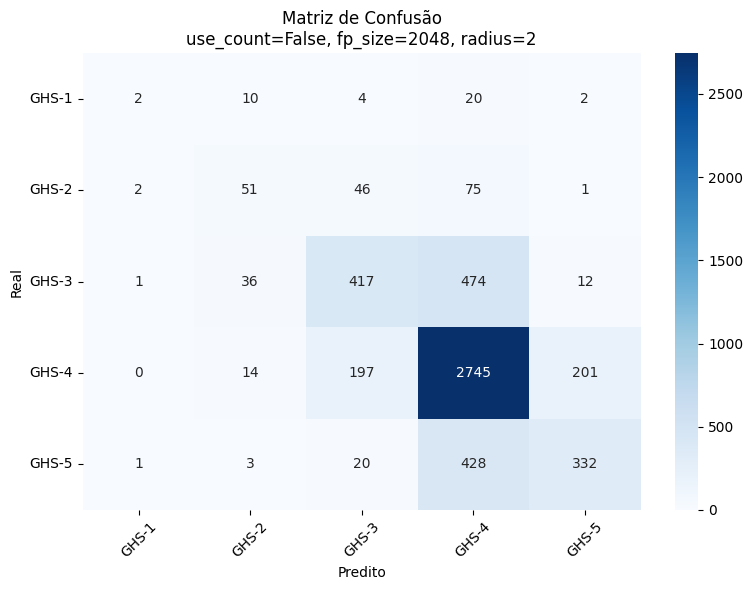

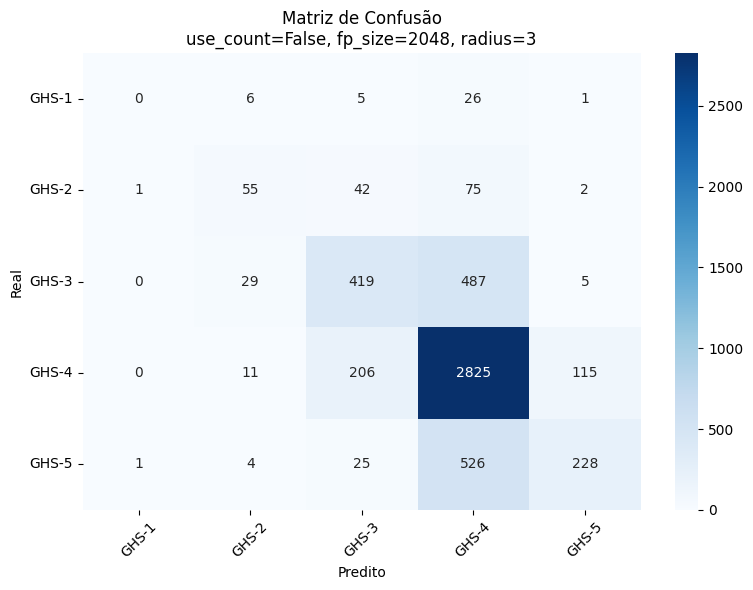

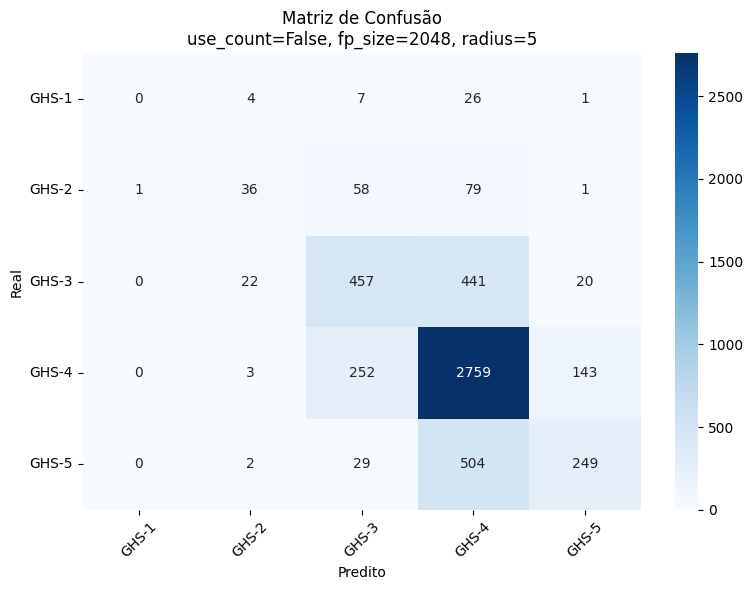

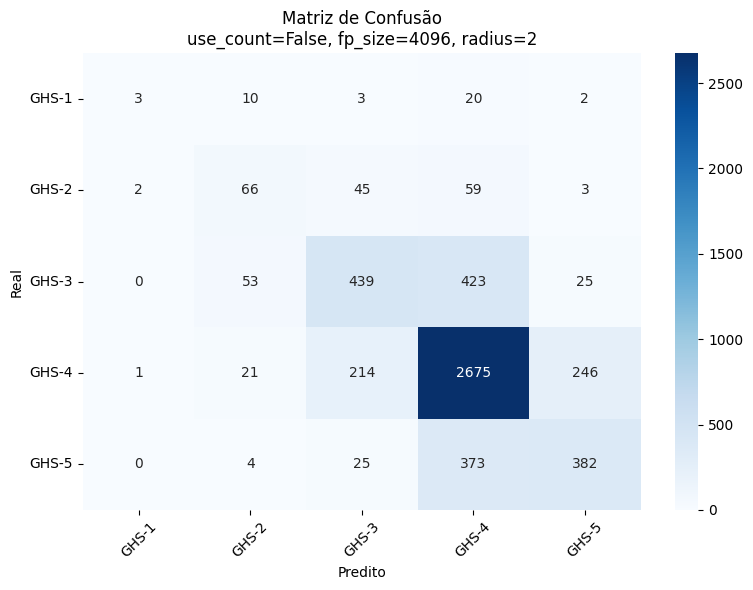

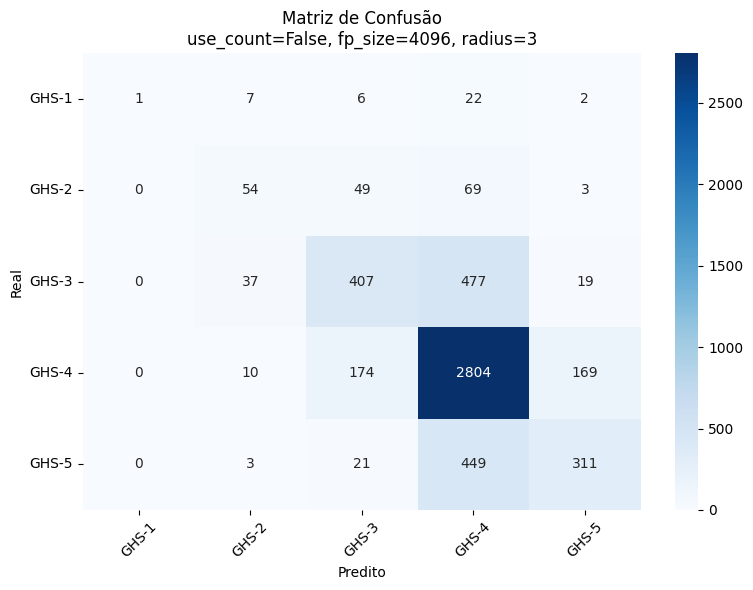

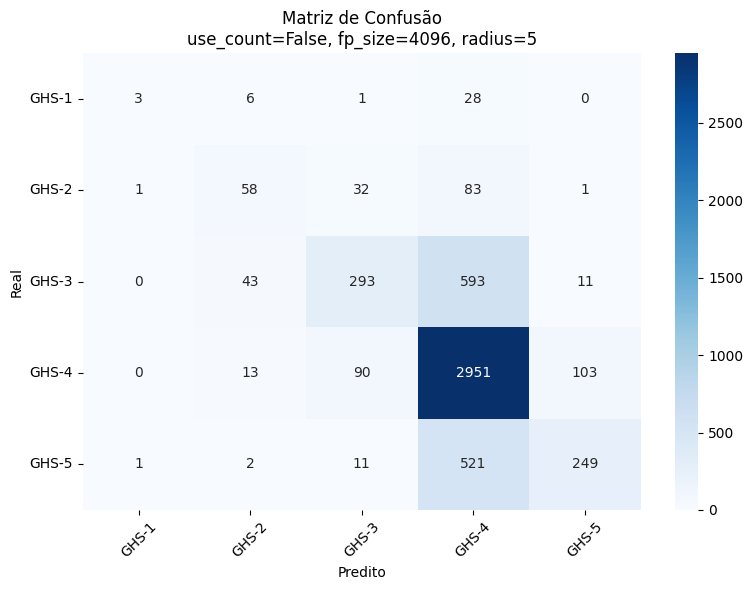

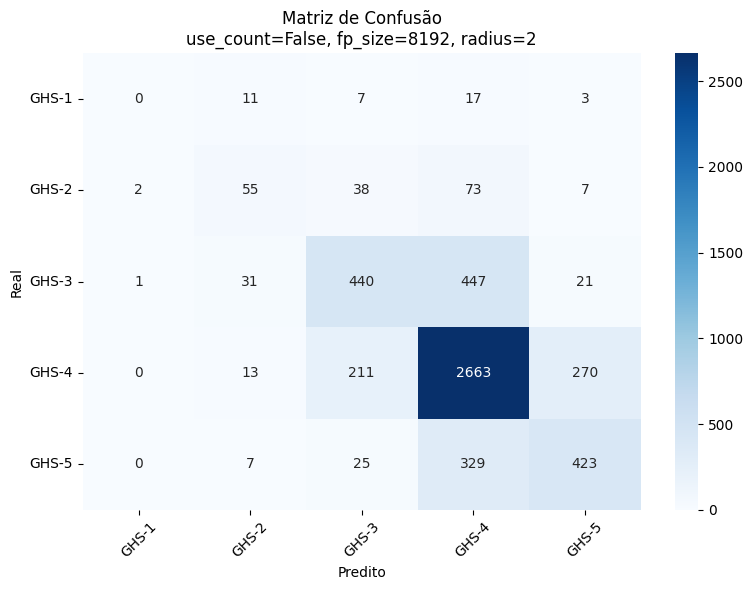

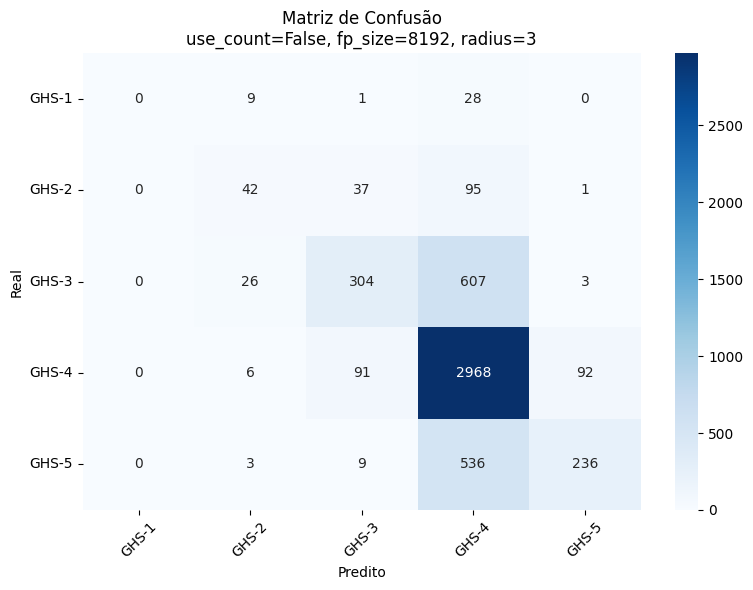

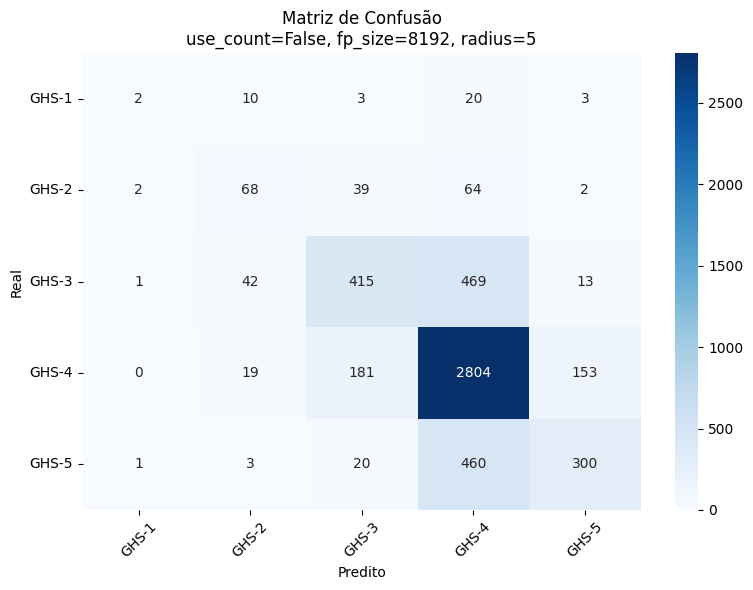

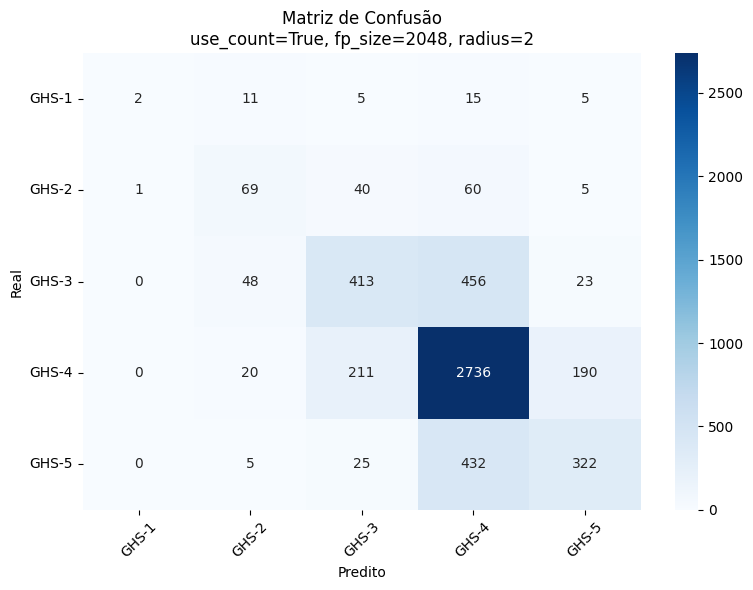

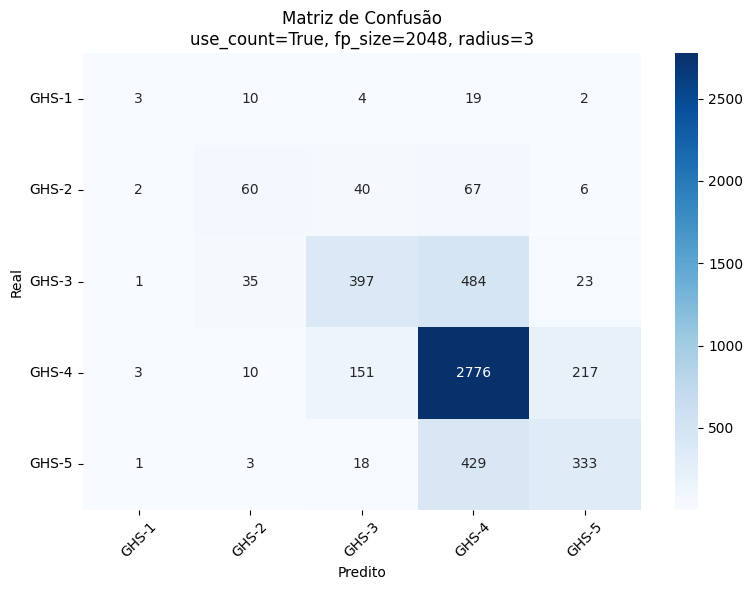

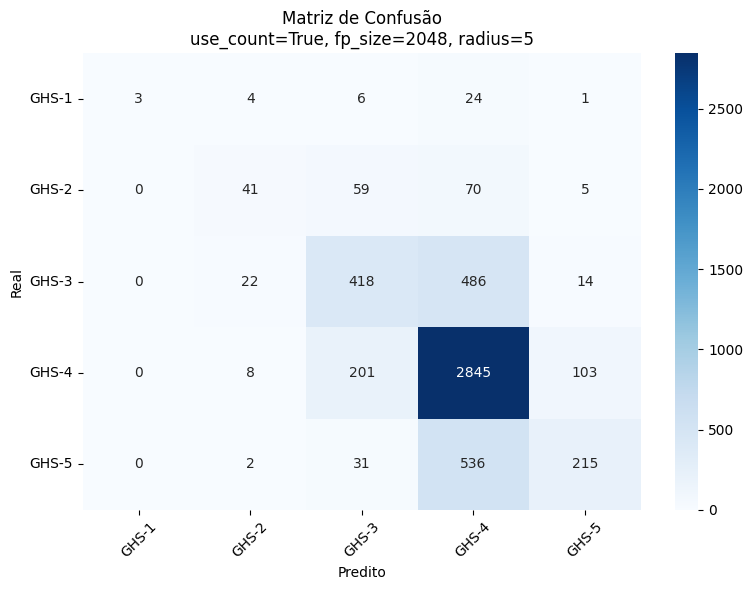

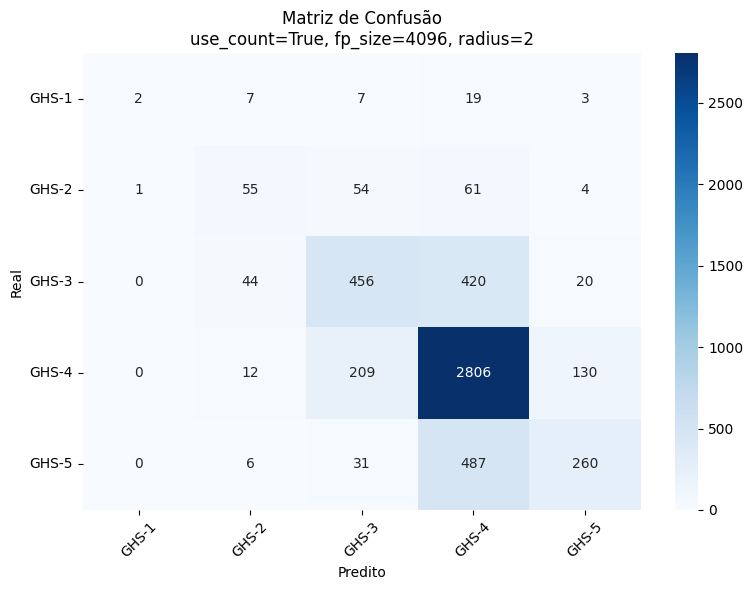

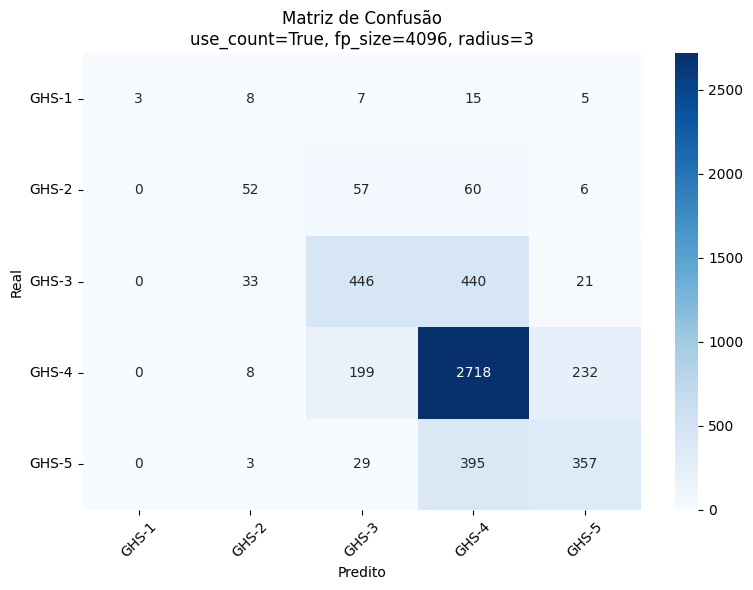

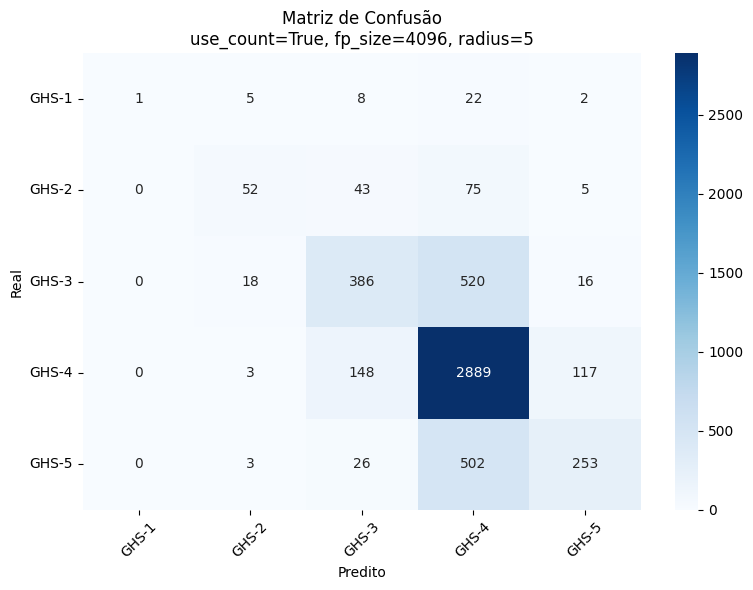

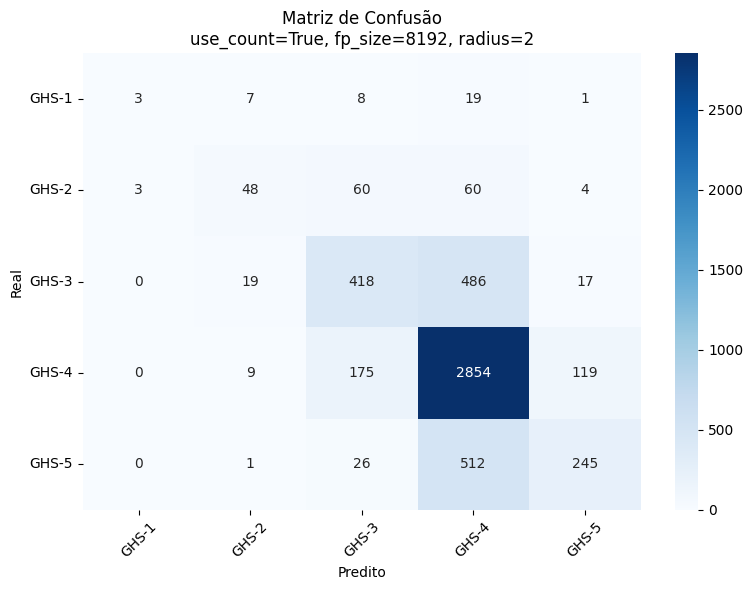

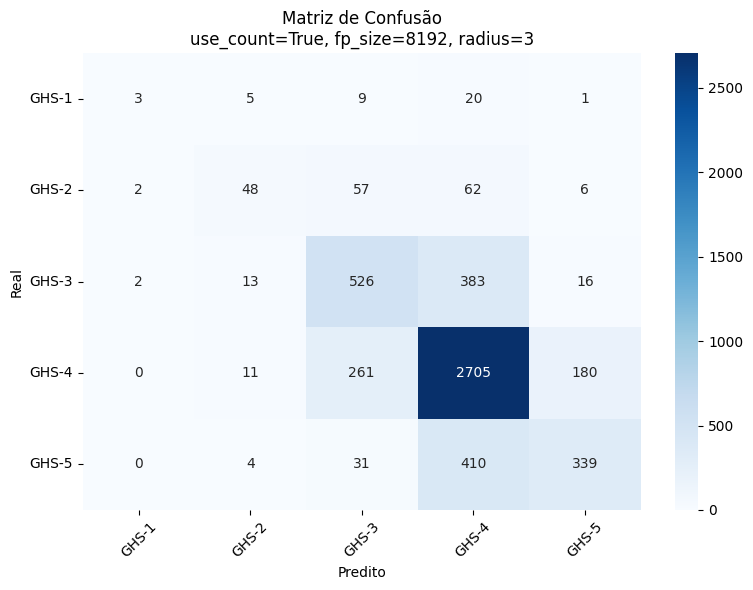

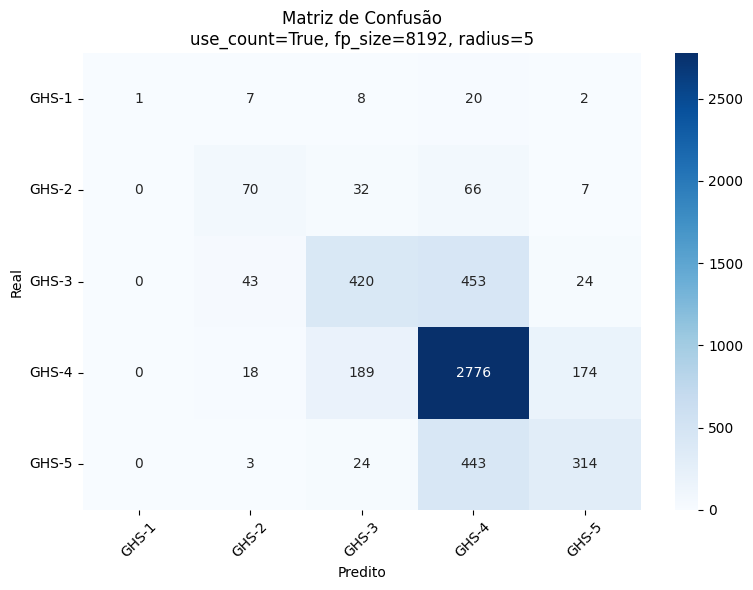


Ranking de combinações por acurácia:
    use_count  fp_size  radius  accuracy
16       True     8192       3  0.710836
8       False     8192       5  0.704554
17       True     8192       5  0.702984
6       False     8192       2  0.702984
14       True     4096       5  0.702984
12       True     4096       2  0.702591
4       False     4096       3  0.702199
13       True     4096       3  0.702002
10       True     2048       3  0.700628
15       True     8192       2  0.700432
3       False     4096       2  0.699843
5       False     4096       5  0.697684
7       False     8192       3  0.696898
0       False     2048       2  0.696309
9        True     2048       2  0.695328
1       False     2048       3  0.692383
11       True     2048       5  0.691402
2       False     2048       5  0.687279


In [14]:
# Configurações do experimento
arquivo_classificado = "mouse_vo_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]  
exibir_plot = True  

# Carregamento e pré-processamento dos dados
df = pd.read_csv(arquivo_classificado)

print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1

classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

# Inicialização da lista para armazenar resultados
resultados = []

# Loop de grid
for use_count in use_count_option:
    for fp_size in fp_size_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fp_size={fp_size}, radius={radius}")

            try: 
                # Geração de fingerprints
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fp_size=fp_size,
                    use_count=use_count
                )

                # Remove moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Definição das variáveis X e y
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

                # Construção do modelo
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # Evitar overfitting
                early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

                # Treinamento do Modelo
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stop], verbose=0)
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Salva os dados para plot posterior
                resultados.append({
                    "use_count": use_count,
                    "fp_size": fp_size,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fp_size={fp_size}, radius={radius}")
                print(e)

# === GERAÇÃO E SALVAMENTO DOS PLOTS ===
for r in resultados:
    try:
        use_count = r["use_count"]
        fp_size = r["fp_size"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"confusion_uc-{use_count}_fp-{fp_size}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fp_size={fp_size}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fp_size}, r={radius}")
        print(e)

# === RANKING FINAL ===
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")

# Cria diretório de resultados, se ainda não existir
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Caminho completo do arquivo CSV
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salva o DataFrame (sem colunas de y_test/y_pred, pois são grandes arrays)
resultados_df.to_csv(csv_path, index=False)

# Análise de toxicidade intravenosa em camundongos

--- Mapeando categorias GHS para softmax ---

Testando: use_count=False, fp_size=2048, radius=2


[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:19] WARNING: not removing hydrogen atom without neighbors
[20:12:20] WARNING: not removing hydrogen atom without neighbors
[20:12:20] WARNING: not removing hydrogen atom without neighbors
[20:12:20] WARNING: not removing hydrogen atom without neighbors
[20:12:20] WARNING: not removing hydrogen atom without neighbors
[20:12:20] WARNING: not removing hydrogen atom without neighbors
[20:12:20] Unusual charge on atom 4 number of radical electrons set to zero
[20:12:20] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.6478589420654912

Testando: use_count=False, fp_size=2048, radius=3


[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:34] WARNING: not removing hydrogen atom without neighbors
[20:12:35] WARNING: not removing hydrogen atom without neighbors
[20:12:35] WARNING: not removing hydrogen atom without neighbors
[20:12:35] WARNING: not removing hydrogen atom without neighbors
[20:12:35] Unusual charge on atom 4 number of radical electrons set to zero
[20:12:35] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.6322418136020151

Testando: use_count=False, fp_size=2048, radius=5


[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:49] WARNING: not removing hydrogen atom without neighbors
[20:12:50] WARNING: not removing hydrogen atom without neighbors
[20:12:50] WARNING: not removing hydrogen atom without neighbors
[20:12:50] WARNING: not removing hydrogen atom without neighbors
[20:12:50] Unusual charge on atom 4 number of radical electrons set to zero
[20:12:50] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.6375314861460957

Testando: use_count=False, fp_size=4096, radius=2


[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:04] WARNING: not removing hydrogen atom without neighbors
[20:13:05] WARNING: not removing hydrogen atom without neighbors
[20:13:05] WARNING: not removing hydrogen atom without neighbors
[20:13:05] WARNING: not removing hydrogen atom without neighbors
[20:13:05] Unusual charge on atom 4 number of radical electrons set to zero
[20:13:05] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.655919395465995

Testando: use_count=False, fp_size=4096, radius=3


[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:22] WARNING: not removing hydrogen atom without neighbors
[20:13:23] WARNING: not removing hydrogen atom without neighbors
[20:13:23] WARNING: not removing hydrogen atom without neighbors
[20:13:23] WARNING: not removing hydrogen atom without neighbors
[20:13:23] Unusual charge on atom 4 number of radical electrons set to zero
[20:13:23] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6473551637279596

Testando: use_count=False, fp_size=4096, radius=5


[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:40] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:41] WARNING: not removing hydrogen atom without neighbors
[20:13:42] Unusual charge on atom 4 number of radical electrons set to zero
[20:13:42] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.6493702770780856

Testando: use_count=False, fp_size=8192, radius=2


[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:13:59] WARNING: not removing hydrogen atom without neighbors
[20:14:00] WARNING: not removing hydrogen atom without neighbors
[20:14:00] WARNING: not removing hydrogen atom without neighbors
[20:14:00] WARNING: not removing hydrogen atom without neighbors
[20:14:00] WARNING: not removing hydrogen atom without neighbors
[20:14:01] WARNING: not removing hydrogen atom without neighbors
[20:14:01] WARNING: not removing hydrogen atom without neighbors
[20:14:01] WARNING: not removing hydrogen atom without neighbors
[20:14:01] Unusual charge on atom 4 number of radical electrons set to zero
[20:14:01] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6604534005037783

Testando: use_count=False, fp_size=8192, radius=3


[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:28] WARNING: not removing hydrogen atom without neighbors
[20:14:29] WARNING: not removing hydrogen atom without neighbors
[20:14:29] WARNING: not removing hydrogen atom without neighbors
[20:14:29] WARNING: not removing hydrogen atom without neighbors
[20:14:29] Unusual charge on atom 4 number of radical electrons set to zero
[20:14:29] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6541561712846348

Testando: use_count=False, fp_size=8192, radius=5


[20:14:55] WARNING: not removing hydrogen atom without neighbors
[20:14:55] WARNING: not removing hydrogen atom without neighbors
[20:14:55] WARNING: not removing hydrogen atom without neighbors
[20:14:55] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:56] WARNING: not removing hydrogen atom without neighbors
[20:14:57] Unusual charge on atom 4 number of radical electrons set to zero
[20:14:57] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6372795969773299

Testando: use_count=True, fp_size=2048, radius=2


[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:21] WARNING: not removing hydrogen atom without neighbors
[20:15:22] WARNING: not removing hydrogen atom without neighbors
[20:15:22] WARNING: not removing hydrogen atom without neighbors
[20:15:22] WARNING: not removing hydrogen atom without neighbors
[20:15:22] Unusual charge on atom 4 number of radical electrons set to zero
[20:15:22] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.6448362720403022

Testando: use_count=True, fp_size=2048, radius=3


[20:15:35] WARNING: not removing hydrogen atom without neighbors
[20:15:35] WARNING: not removing hydrogen atom without neighbors
[20:15:35] WARNING: not removing hydrogen atom without neighbors
[20:15:35] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:36] WARNING: not removing hydrogen atom without neighbors
[20:15:37] Unusual charge on atom 4 number of radical electrons set to zero
[20:15:37] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.6410579345088161

Testando: use_count=True, fp_size=2048, radius=5


[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:49] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:50] WARNING: not removing hydrogen atom without neighbors
[20:15:51] Unusual charge on atom 4 number of radical electrons set to zero
[20:15:51] WAR

125/125 [==============================] - 0s 1ms/step
Acurácia: 0.643073047858942

Testando: use_count=True, fp_size=4096, radius=2


[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:04] WARNING: not removing hydrogen atom without neighbors
[20:16:05] WARNING: not removing hydrogen atom without neighbors
[20:16:05] WARNING: not removing hydrogen atom without neighbors
[20:16:05] WARNING: not removing hydrogen atom without neighbors
[20:16:05] Unusual charge on atom 4 number of radical electrons set to zero
[20:16:05] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6523929471032746

Testando: use_count=True, fp_size=4096, radius=3


[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:22] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] WARNING: not removing hydrogen atom without neighbors
[20:16:23] Unusual charge on atom 4 number of radical electrons set to zero
[20:16:23] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6375314861460957

Testando: use_count=True, fp_size=4096, radius=5


[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:39] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] WARNING: not removing hydrogen atom without neighbors
[20:16:40] Unusual charge on atom 4 number of radical electrons set to zero
[20:16:40] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6302267002518892

Testando: use_count=True, fp_size=8192, radius=2


[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:56] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] Unusual charge on atom 4 number of radical electrons set to zero
[20:16:57] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6569269521410579

Testando: use_count=True, fp_size=8192, radius=3


[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:24] WARNING: not removing hydrogen atom without neighbors
[20:17:25] WARNING: not removing hydrogen atom without neighbors
[20:17:25] WARNING: not removing hydrogen atom without neighbors
[20:17:25] WARNING: not removing hydrogen atom without neighbors
[20:17:25] Unusual charge on atom 4 number of radical electrons set to zero
[20:17:25] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6523929471032746

Testando: use_count=True, fp_size=8192, radius=5


[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:52] WARNING: not removing hydrogen atom without neighbors
[20:17:53] WARNING: not removing hydrogen atom without neighbors
[20:17:53] WARNING: not removing hydrogen atom without neighbors
[20:17:53] WARNING: not removing hydrogen atom without neighbors
[20:17:53] Unusual charge on atom 4 number of radical electrons set to zero
[20:17:53] WAR

125/125 [==============================] - 0s 2ms/step
Acurácia: 0.6581863979848867


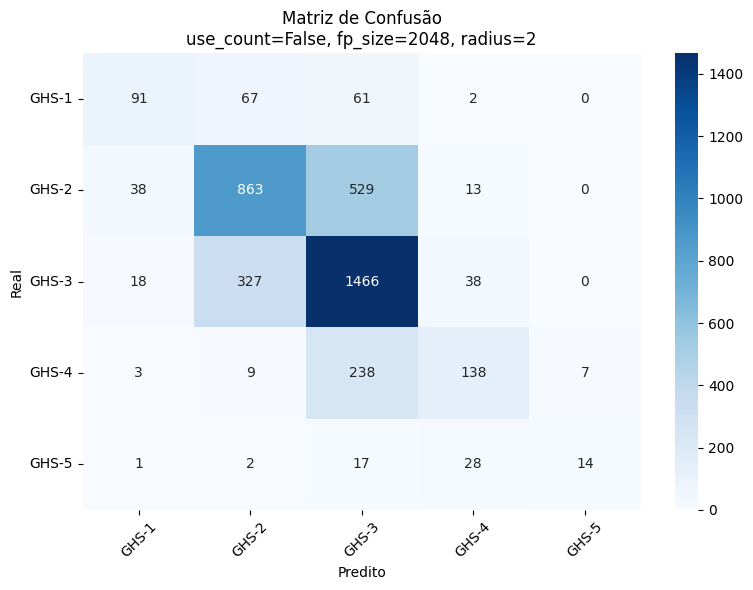

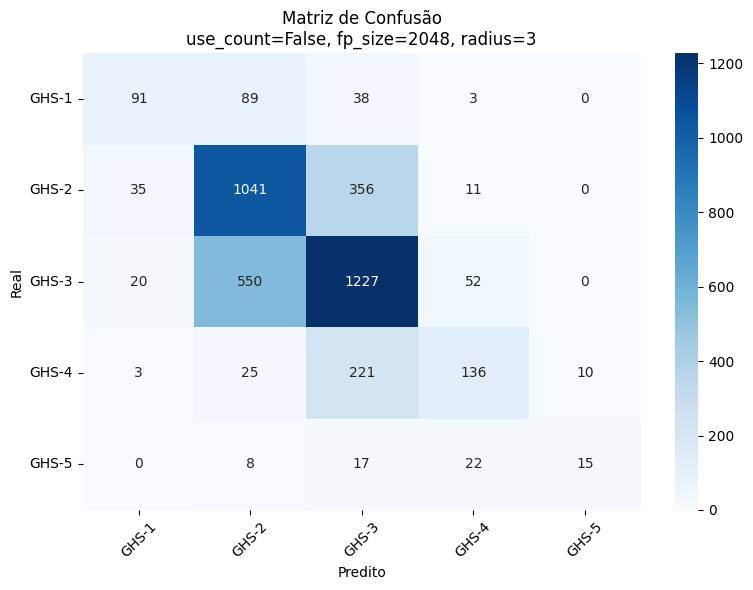

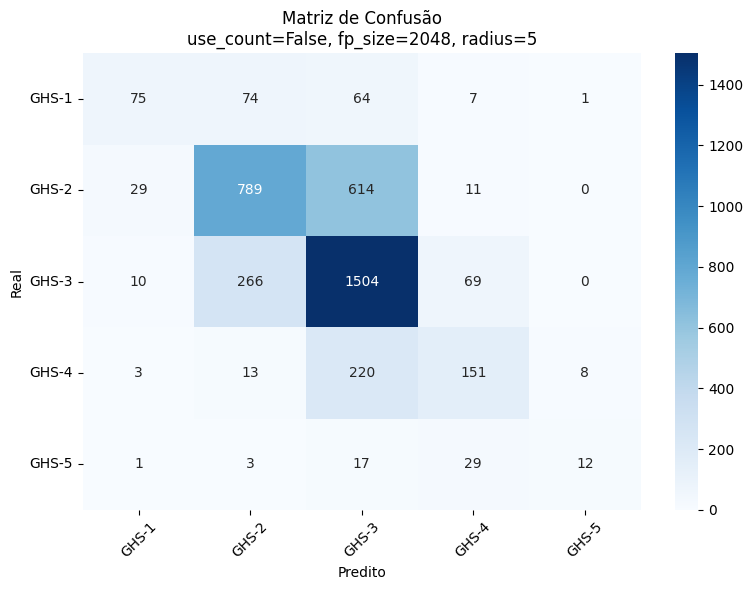

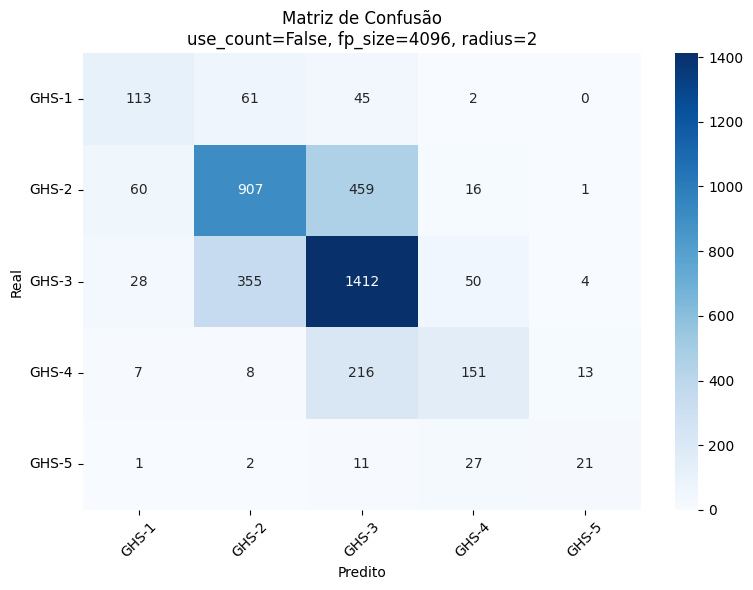

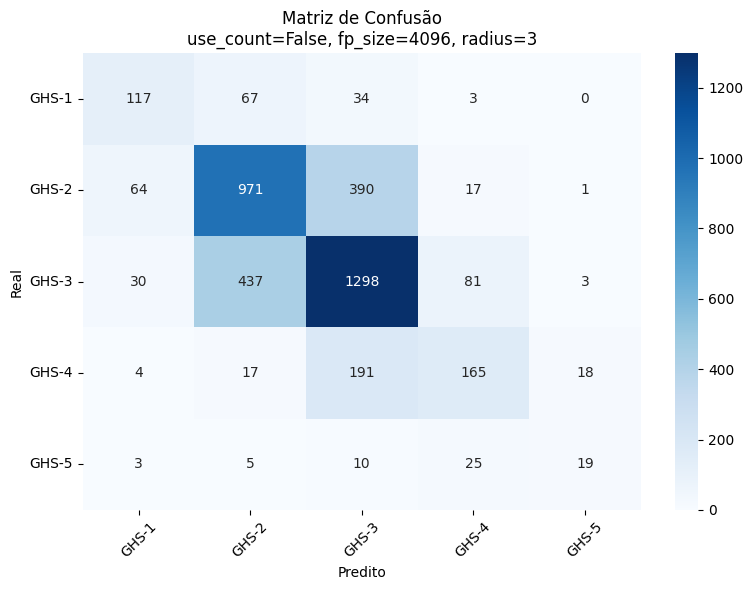

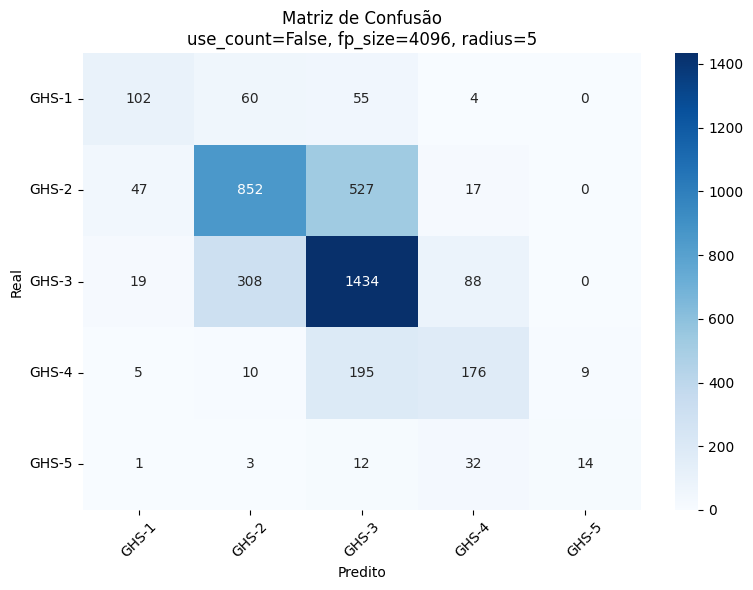

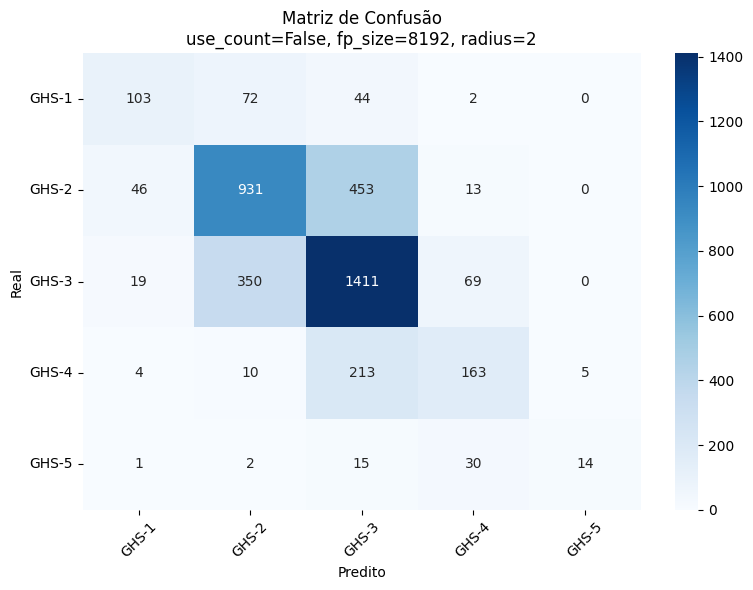

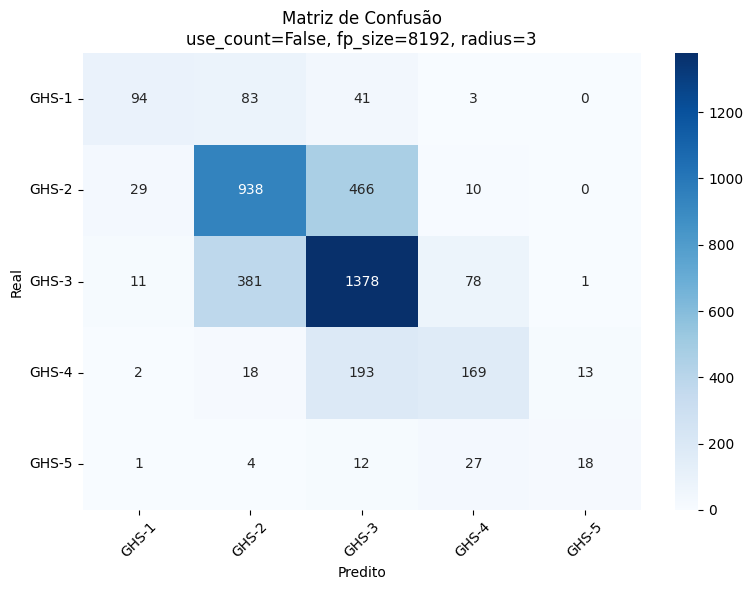

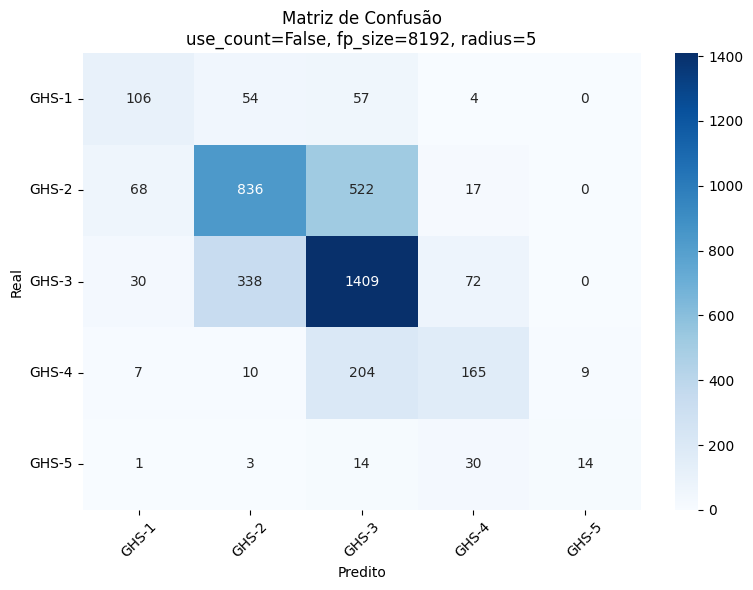

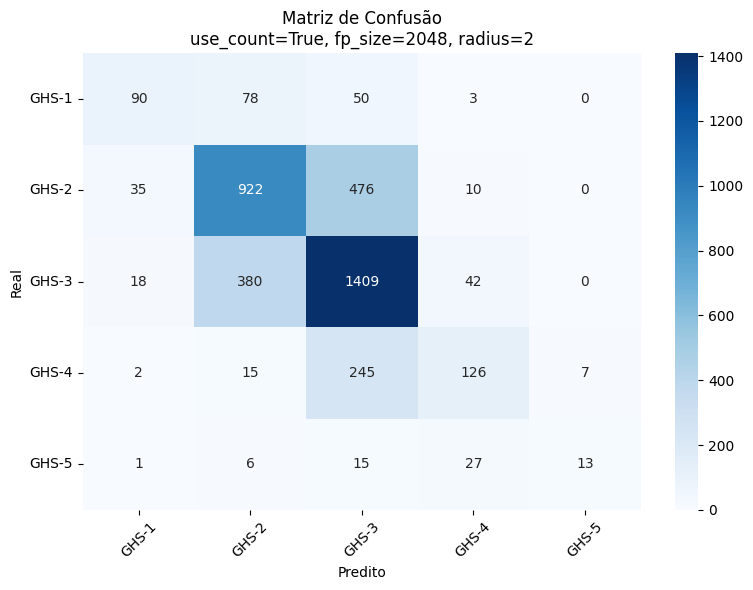

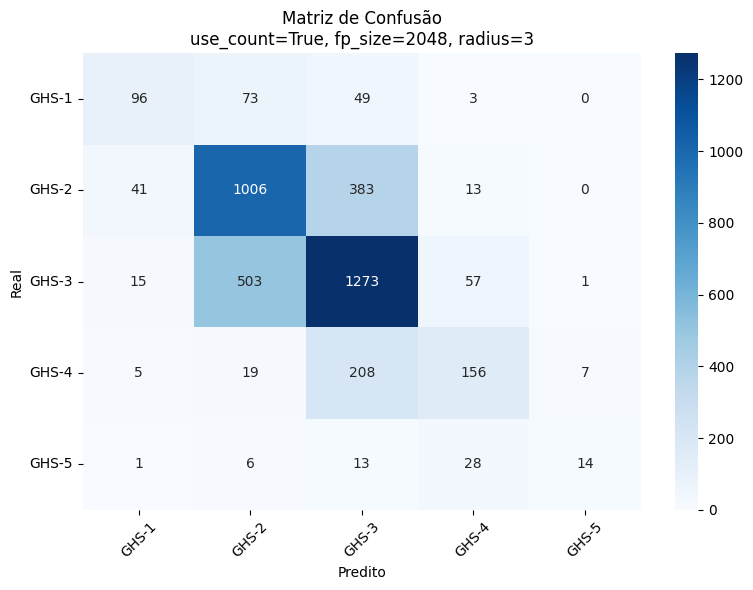

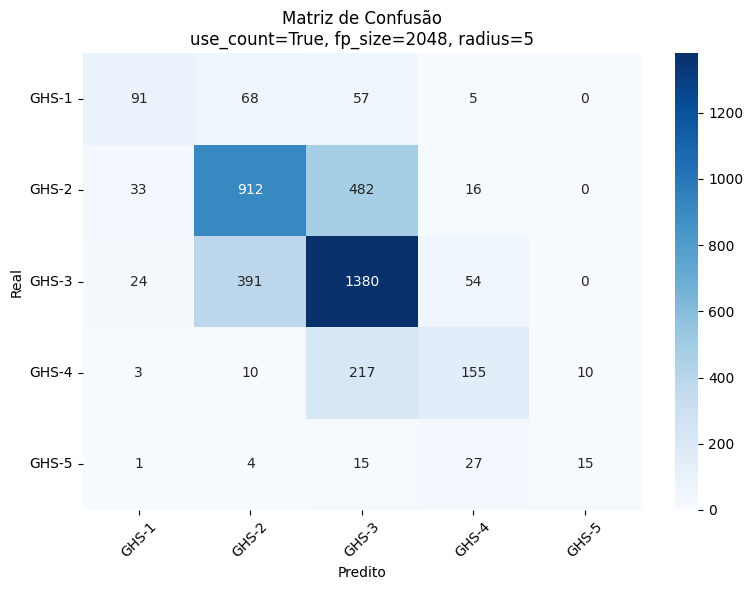

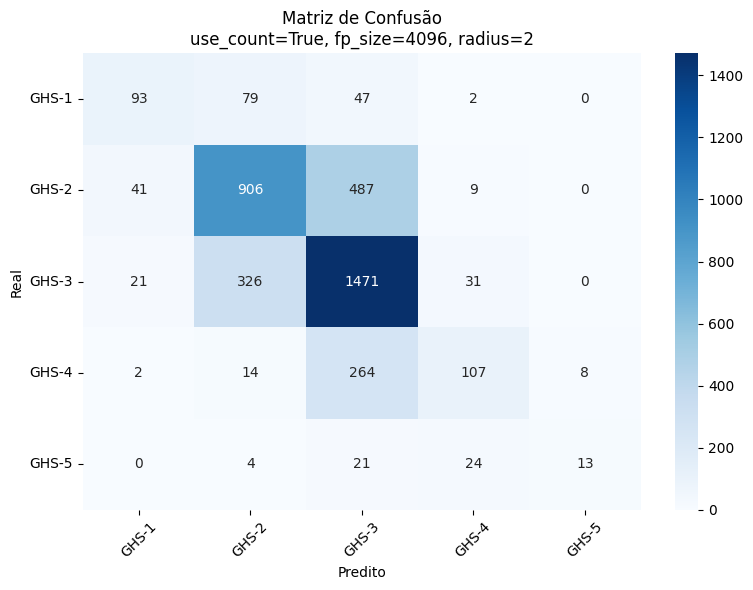

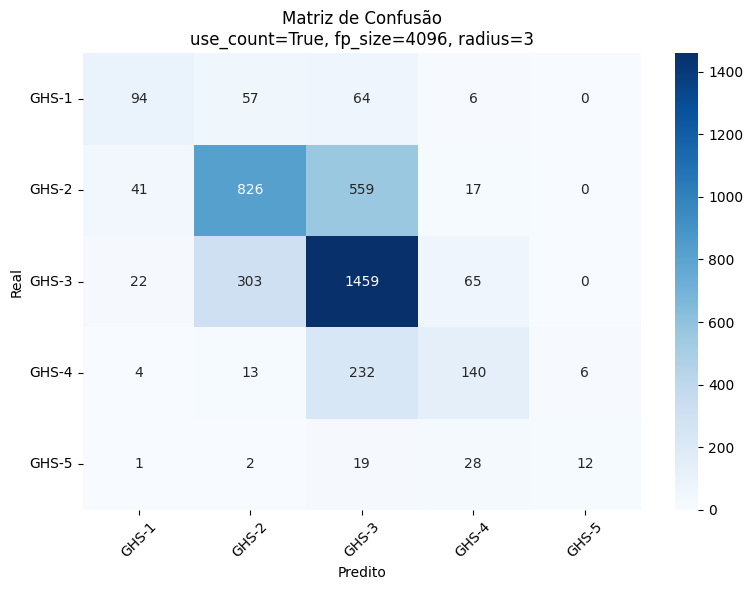

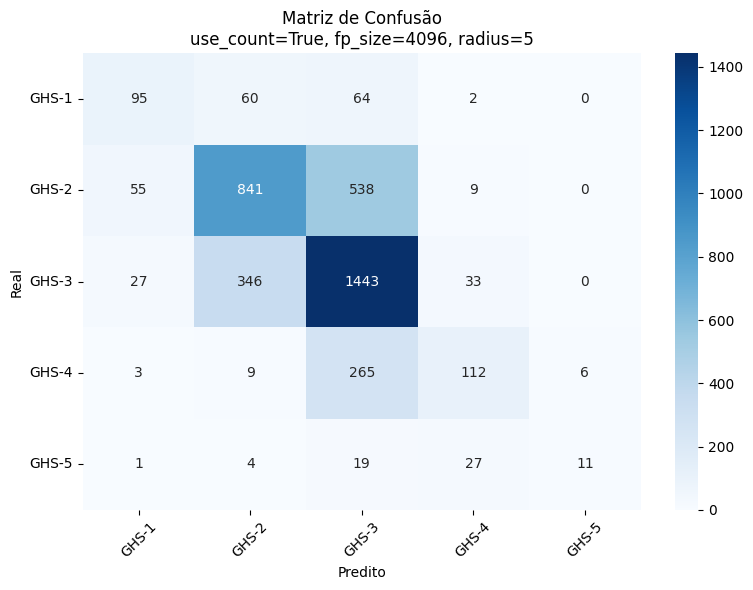

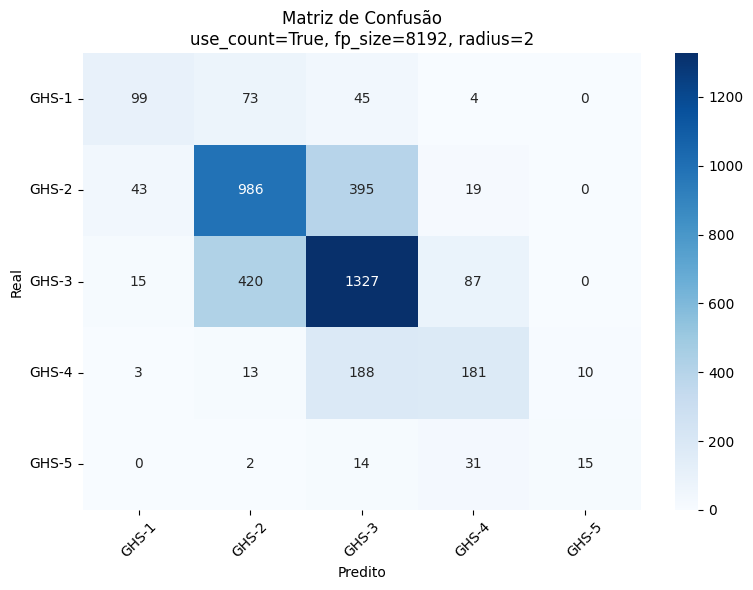

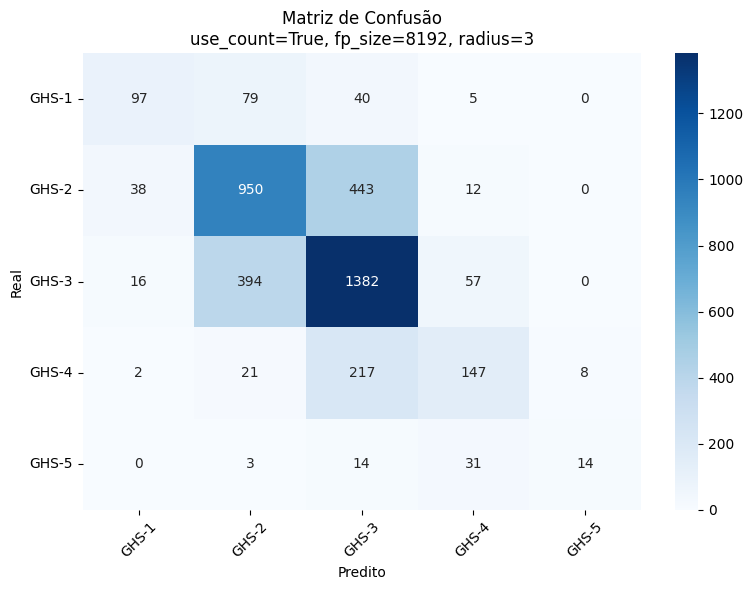

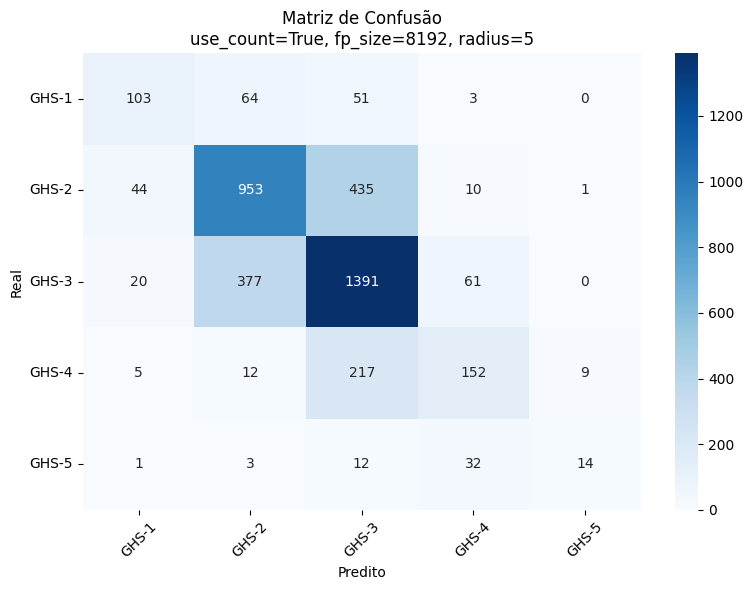


Ranking de combinações por acurácia:
    use_count  fp_size  radius  accuracy
6       False     8192       2  0.660453
17       True     8192       5  0.658186
15       True     8192       2  0.656927
3       False     4096       2  0.655919
7       False     8192       3  0.654156
12       True     4096       2  0.652393
16       True     8192       3  0.652393
5       False     4096       5  0.649370
0       False     2048       2  0.647859
4       False     4096       3  0.647355
9        True     2048       2  0.644836
11       True     2048       5  0.643073
10       True     2048       3  0.641058
13       True     4096       3  0.637531
2       False     2048       5  0.637531
8       False     8192       5  0.637280
1       False     2048       3  0.632242
14       True     4096       5  0.630227


In [16]:
# Configurações do experimento
arquivo_classificado = "mouse_vi_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]  
exibir_plot = True  

# Carregamento e pré-processamento dos dados
df = pd.read_csv(arquivo_classificado)

print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1

classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

# Inicialização da lista para armazenar resultados
resultados = []

# Loop de grid
for use_count in use_count_option:
    for fp_size in fp_size_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fp_size={fp_size}, radius={radius}")

            try: 
                # Geração de fingerprints
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fp_size=fp_size,
                    use_count=use_count
                )

                # Remove moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Definição das variáveis X e y
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

                # Construção do modelo
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # Evitar overfitting
                early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

                # Treinamento do Modelo
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stop], verbose=0)
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Salva os dados para plot posterior
                resultados.append({
                    "use_count": use_count,
                    "fp_size": fp_size,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fp_size={fp_size}, radius={radius}")
                print(e)

# === GERAÇÃO E SALVAMENTO DOS PLOTS ===
for r in resultados:
    try:
        use_count = r["use_count"]
        fp_size = r["fp_size"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"confusion_uc-{use_count}_fp-{fp_size}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fp_size={fp_size}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fp_size}, r={radius}")
        print(e)

# === RANKING FINAL ===
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")
    
    # Cria diretório de resultados, se ainda não existir
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Caminho completo do arquivo CSV
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salva o DataFrame (sem colunas de y_test/y_pred, pois são grandes arrays)
resultados_df.to_csv(csv_path, index=False)